# **Dependencies**

In [1]:
import os

# Locate the APNet root directory
current_path = os.getcwd()
while not os.path.exists(os.path.join(current_path, "README.md")):
    current_path = os.path.dirname(current_path)

# Set the current working directory to the APNet root
os.chdir(current_path)
print(f"Working directory set to: {os.getcwd()}")

Working directory set to: /Users/georgegavriilidis/APNet


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
import networkx as nx
from adjustText import adjust_text
import gc
import random
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
import networkx as nx
import math
from matplotlib.image import imread

In [3]:
import string

In [4]:
import logging

# Network assembly

We are going to create here a function to design a driver-pathway multipartite graph based on PASNet results.

In [5]:
def network_reconstruction(sc1_path, sjaracne_path, top_shap_proteins, differential_activity_path):
    """Reconstruct a network from the provided data and incorporate node attributes."""
    logging.info("Reconstructing network using:")
    logging.info(f"- Deep Learning protein-pathway weights (SC1): {sc1_path}")
    logging.info(f"- SJARACNe protein-protein coregulation file: {sjaracne_path}")
    logging.info(f"- Differential activity file: {differential_activity_path}")

    # Memory cleanup
    gc.collect()

    # Create graph
    G = nx.Graph()

    # Step 1: Load and process SC1 data
    try:
        correlation_matrix = pd.read_excel(sc1_path, engine='openpyxl', index_col=0)
        logging.info("SC1 file successfully loaded.")
        data = [
            (pathway, gene, value)
            for pathway, series in correlation_matrix.iterrows()
            for gene, value in series.items()
        ]
        df = pd.DataFrame(data, columns=['source', 'target', 'Weight'])

        # Remove edges with Weight == 0
        df = df[df['Weight'] != 0]

        df['handler'] = df.apply(lambda row: 'get' if row['source'] in top_shap_proteins or row['target'] in top_shap_proteins else None, axis=1)
    except Exception as e:
        logging.error(f"Error processing SC1 file: {e}")
        return None


    # Step 2: Load and process SJARACNe data
    try:
        df_sj = pd.read_csv(sjaracne_path, sep='\t')
        logging.info("SJARACNe file successfully loaded.")

        # Rename problematic columns
        df_sj.columns = [col.replace('.', '_').replace('-', '_') for col in df_sj.columns]

        # Check for required columns
        required_columns = ['source', 'target', 'MI', 'spearman', 'p_value']
        missing_columns = [col for col in required_columns if col not in df_sj.columns]
        if missing_columns:
            logging.error(f"Missing columns in SJARACNe data: {missing_columns}")
            return None

        genes_list = pd.concat([df['source'], df['target']]).unique().tolist()
        df_sj = df_sj[df_sj['source'].isin(genes_list) | df_sj['target'].isin(genes_list)]
        df_sj = df_sj[['source', 'target', 'MI', 'spearman', 'p_value']]
        df_sj['Weight'] = None
        df_sj = df_sj[df_sj['p_value'] <= 0.05]
        df_sj['handler'] = df_sj.apply(lambda row: 'get' if row['source'] in top_shap_proteins and row['target'] in top_shap_proteins else None, axis=1)
    except Exception as e:
        logging.error(f"Error processing SJARACNe file: {e}")
        return None


    # Step 3: Combine SC1 and SJARACNe data
    try:
        combined_df = pd.concat([df, df_sj], ignore_index=True)
        combined_df = combined_df.drop_duplicates(subset=['source', 'target'])  # Remove duplicate edges
        logging.info("Data from SC1 and SJARACNe combined successfully.")
    except Exception as e:
        logging.error(f"Error combining data: {e}")
        return None


    # Step 4: Load and process differential activity data
    try:
        node_attr_proteins = pd.read_csv(differential_activity_path)
        logging.info("Differential activity file successfully loaded.")
        # Replace problematic column names with underscores
        node_attr_proteins.columns = [col.replace('.', '_').replace('-', '_') for col in node_attr_proteins.columns]

        if 'type' not in node_attr_proteins.columns:
            node_attr_proteins['type'] = 'proteins'
        else:
            node_attr_proteins['type'] = node_attr_proteins['type'].fillna('proteins')
        node_attr_proteins['Top20ShapDriver_or_pathway'] = node_attr_proteins['ID'].apply(lambda x: 'yes' if x in top_shap_proteins else 'no')

        # Print problematic column names
        required_columns = ['label', 'type', 'ID', 'logFC', 'AveExpr', 't', 'P_Value', 'adj_P_Val', 'Z_statistics',
                            'Ave_NonSevere', 'Ave_Severe', 'Top20ShapDriver_or_pathway']
        missing_columns = [col for col in required_columns if col not in node_attr_proteins.columns]
        if missing_columns:
            logging.warning(f"Missing columns in node attributes: {missing_columns}")
    except Exception as e:
        logging.error(f"Error processing differential activity file: {e}")
        return None

    # Step 5: Add edges to the graph
    try:
        for row in combined_df.itertuples(index=False):
            source, target = row.source, row.target
            edge_attributes = {col: getattr(row, col, None) for col in combined_df.columns if col not in ['source', 'target']}
            if not G.has_edge(source, target):  # Prevent duplicate edges
                G.add_edge(source, target, **edge_attributes)
    except Exception as e:
        logging.error(f"Error adding edges to the graph: {e}")
        return None

    # Step 6: Add node attributes
    try:
        for row in node_attr_proteins.itertuples(index=False):
            if row.ID in G.nodes:
                attributes = row._asdict()
                attributes.pop('Index', None)  # Remove the index column
                G.nodes[row.ID].update(attributes)
    except Exception as e:
        logging.error(f"Error adding node attributes: {e}")
        return None

    # Step 7: Add label attribute
    try:
        for node in G.nodes:
            G.nodes[node]['label'] = str(node)  # Set 'label' attribute to node name (convert to string if needed)
    except Exception as e:
        logging.error(f"Error adding label attribute: {e}")
        return None

    # Step 8: Replace NaN in 'type' column with 'pathways'
    try:
        for node, data in G.nodes(data=True):
            if 'type' not in data or pd.isna(data['type']):
                G.nodes[node]['type'] = 'pathways'
    except Exception as e:
        logging.error(f"Error updating 'type' attribute: {e}")
        return None

    logging.info(f"Network constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

We select the inputs based on APNet_model_1 which relates to the bulk proteomic APNet scenario (MGH-Mayo-Stanford).

In [6]:
# Simulated arguments for testing in Colab
sc1_path = "./data/PASNet/APNet_model_1/outs/sc1_weights_fixed_dec24.xlsx" # these are the learning weights that PASNet has given on the driver-pathway connections during predictions
sjaracne_path = "./data/NetBID2/outs/consensus_network_ncol_MGH.txt" # NetBID2 output which represents a SJARACNe network file from the MGH dataset; it could easily be Mayo or Stanford
top_shap_proteins = ["TNFRSF10A", "JUN", "IL6", "BAX", "TNFRSF1A", "LYN",
    "TNFRSF10B", "ITGB1", "COL9A1", "ACAA1", "MAPK9", "PLAUR",
    "S100P", "CKAP4", "CCL7", "PTEN", "CCL20", "TRIAP1",
    "POLR2F", "TNFSF11", "COL1A1", "ITGA5", "HSPA1A", "PRTN3"] # All the top SHAP proteins that emerged from the optimisation/validation (Mayo) and testing phases (Stanford)
differential_activity_path = "./data/NetBID2/outs/DA_MGH.csv" # NetBID2 output related to differential activity analysis from the MGH dataset; for Mayo and Stanford variations adjust accordingly

# Run the function
G = network_reconstruction(sc1_path, sjaracne_path, top_shap_proteins, differential_activity_path)

# Optionally inspect the graph
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

/var/folders/hr/f3msc_bs3z53n3_m4c4ry6tc0000gn/T/ipykernel_3473/3556185497.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([df, df_sj], ignore_index=True)


Nodes: 1373, Edges: 6161


In [8]:
# Sanity check 2: Inspect node attributes
node_attributes = {node: G.nodes[node] for node in G.nodes()}
node_df = pd.DataFrame(node_attributes).T

print("Node Attributes:")
print(node_df)

Node Attributes:
                                           label      type         ID  \
AGE/RAGE pathway WP2324  AGE/RAGE pathway WP2324  pathways        NaN   
CASP8                                      CASP8  proteins      CASP8   
EZR                                          EZR  proteins        EZR   
JUN                                          JUN  proteins        JUN   
MAPK9                                      MAPK9  proteins      MAPK9   
...                                          ...       ...        ...   
THBD                                        THBD  proteins       THBD   
VSTM2L                                    VSTM2L  proteins     VSTM2L   
TXNDC5                                    TXNDC5  proteins     TXNDC5   
TNFRSF11A                              TNFRSF11A  proteins  TNFRSF11A   
ULBP2                                      ULBP2  proteins      ULBP2   

                            logFC   AveExpr         t   P_Value adj_P_Val  \
AGE/RAGE pathway WP2324      

In [7]:
# Sanity check 1: Inspect edge attributes
edge_attributes = [{'source': source, 'target': target, **attr}
                   for source, target, attr in G.edges(data=True)]

edge_df = pd.DataFrame(edge_attributes)

print("Edge Attributes:")
print(edge_df)

Edge Attributes:
                       source   target    Weight handler      MI  spearman  \
0     AGE/RAGE pathway WP2324    CASP8 -0.429904    None     NaN       NaN   
1     AGE/RAGE pathway WP2324      EZR -0.679668    None     NaN       NaN   
2     AGE/RAGE pathway WP2324      JUN -0.759906     get     NaN       NaN   
3     AGE/RAGE pathway WP2324    MAPK9 -0.638633     get     NaN       NaN   
4     AGE/RAGE pathway WP2324     MSR1 -0.237507    None     NaN       NaN   
...                       ...      ...       ...     ...     ...       ...   
6156                   ZBTB17    PPCDC       NaN    None  0.3883    0.4894   
6157                   ZBTB17   SETMAR       NaN    None  0.3359    0.4681   
6158                   ZBTB17  TNFRSF8       NaN    None  0.2527    0.4038   
6159                   ZBTB17   TXNRD1       NaN    None  0.3885    0.5042   
6160                   ZBTB17     WARS       NaN    None  0.3829    0.5838   

      p_value  
0         NaN  
1         NaN 

# Predictive subgraph

The driver-pathway graph has 1373 nodes and 6101 edges so it is visually intractable. We will focus on the most predictive nodes meaning top SHAP drivers and connected pathways with high learning weights as edge values.

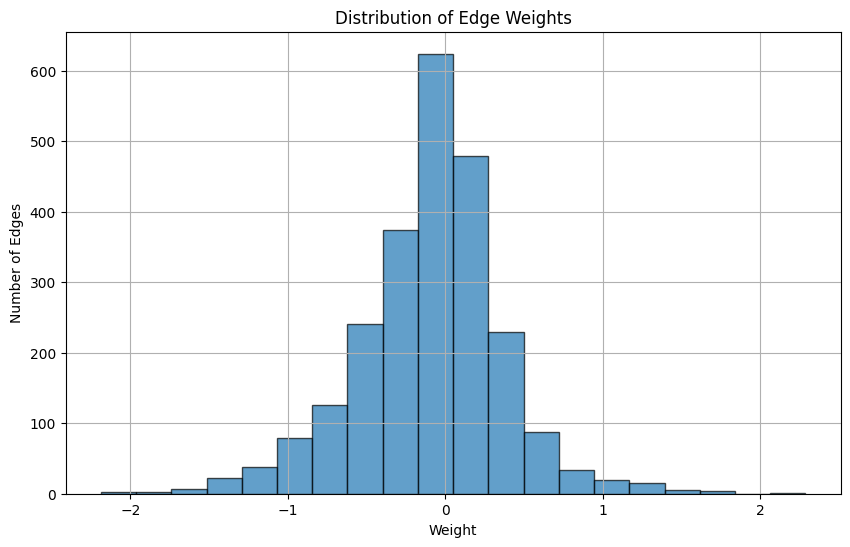

In [8]:
# Extract the 'Weight' attribute values from the edges
weight_values = [data['Weight'] for _, _, data in G.edges(data=True) if 'Weight' in data]

plt.figure(figsize=(10, 6))
plt.hist(weight_values, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Number of Edges')
plt.grid(True)
plt.show()

We define a function to capture a highly prognostic subgraph with top SHAP drivers and prognostic pathways

In [9]:
def highlight_protein_pathway_subnetwork(network, lower_range=(-2.5, -1), upper_range=(1, 2.5)):
    """Highlight specific protein-pathway subnetworks."""
    logging.info("Highlighting protein-pathway subnetwork.")

    # Subset the graph based on edge attributes
    selected_edges = [(u, v) for u, v, e in network.edges(data=True) if e.get('handler') == 'get']
    H = nx.Graph(((u, v, e) for u, v, e in network.edges(data=True) if e.get('handler') == 'get'))

    # Transfer node attributes
    for node, data in network.nodes(data=True):
        if node in H.nodes:
            H.nodes[node].update(data)

    # Filter edges based on weight ranges
    filtered_edges = [(u, v) for u, v, data in H.edges(data=True)
                      if ('Weight' in data and
                          (np.isnan(data['Weight']) or
                           (lower_range[0] <= data['Weight'] <= lower_range[1]) or
                           (upper_range[0] <= data['Weight'] <= upper_range[1])))]

    filtered_subgraph = H.edge_subgraph(filtered_edges).copy()
    logging.info(f"Filtered subgraph has {len(filtered_subgraph.nodes())} nodes and {len(filtered_subgraph.edges())} edges.")

    # Degree-centrality and largest connected component
    components = nx.connected_components(filtered_subgraph)
    largest_component = max(components, key=len)
    F = filtered_subgraph.subgraph(largest_component).copy()

    # Compute centrality
    centrality = nx.betweenness_centrality(F, k=10, endpoints=True)

    # Compute community structure
    lpc = nx.community.label_propagation_communities(F)
    community_index = {n: i for i, com in enumerate(lpc) for n in com}

    # Clean node labels
    def clean_label(label):
        patterns = [r'R-HSA-\d+', r'WP\d+', r'\(GO:\d+\)']
        for pattern in patterns:
            label = re.sub(pattern, '', label)
        return label.strip()

    cleaned_labels = {node: clean_label(node) for node in F.nodes()}

    # Re-draw graph with cleaned labels
    fig, ax = plt.subplots(figsize=(9, 6))
    pos = nx.spring_layout(F, k=0.7, seed=4572321)
    node_color = [community_index[n] for n in F]
    node_size = [v * 5000 for v in centrality.values()]

    nx.draw_networkx_nodes(
        F,
        pos=pos,
        node_color=node_color,
        node_size=node_size,
        alpha=0.4
    )
    nx.draw_networkx_edges(
        F,
        pos=pos,
        edge_color="gainsboro",
        alpha=0.4
    )

    texts = []
    for node, label in cleaned_labels.items():
        x, y = pos[node]
        text = ax.text(x, y, label, fontsize=6, ha='center', va='center')
        texts.append(text)

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")

    # plt.savefig('highlighted_subnetwork.png', format='png', dpi=300)
    plt.show()

    print(f"Network constructed with {F.number_of_nodes()} nodes and {F.number_of_edges()} edges.")

    return F

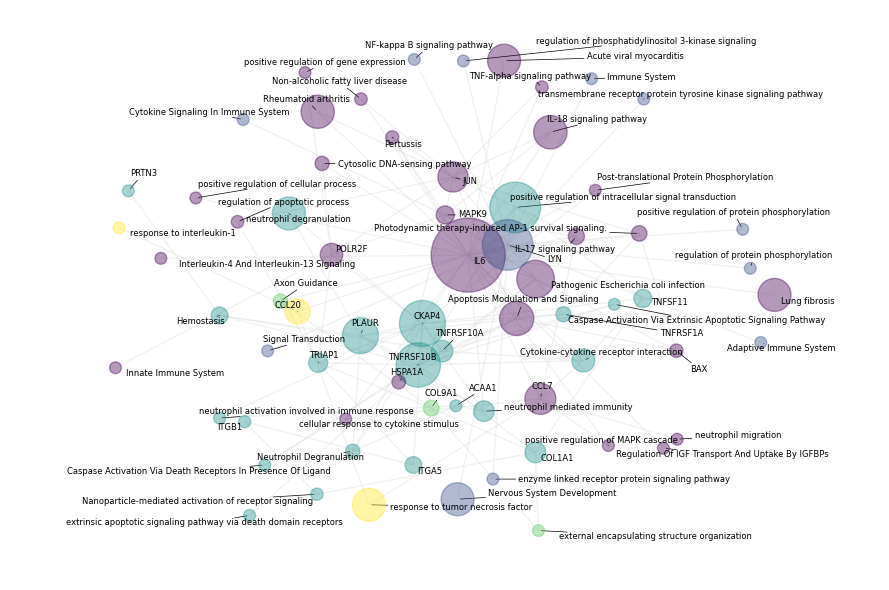

Network constructed with 70 nodes and 126 edges.


In [10]:
H = highlight_protein_pathway_subnetwork(
    network=G,
    lower_range=(-2.5, -0.9), # ranges are arbitrary
    upper_range=(0.9, 2.5)
)

In [ ]:
# Sanity check 2: Inspect node attributes
node_attributes = {node: H.nodes[node] for node in H.nodes()}
node_df = pd.DataFrame(node_attributes).T

print("Node Attributes:")
print(node_df)

Node Attributes:
                                                                                                label  \
Rheumatoid arthritis                                                             Rheumatoid arthritis   
TNFSF11                                                                                       TNFSF11   
Hemostasis R-HSA-109582                                                       Hemostasis R-HSA-109582   
TRIAP1                                                                                         TRIAP1   
positive regulation of cellular process (GO:004...  positive regulation of cellular process (GO:00...   
CKAP4                                                                                           CKAP4   
JUN                                                                                               JUN   
IL-17 signaling pathway                                                       IL-17 signaling pathway   
Pertussis                             

In [11]:
# Sanity check 1: Inspect edge attributes
edge_attributes = [{'source': source, 'target': target, **attr}
                   for source, target, attr in H.edges(data=True)]

edge_df = pd.DataFrame(edge_attributes)

print("Edge Attributes:")
print(edge_df)

Edge Attributes:
                                        source  \
0                                          IL6   
1                                          IL6   
2                                          IL6   
3                                          IL6   
4                                          IL6   
..                                         ...   
121     Neutrophil Degranulation R-HSA-6798695   
122     Neutrophil Degranulation R-HSA-6798695   
123  Apoptosis Modulation and Signaling WP1772   
124                                      CCL20   
125                                      ACAA1   

                                                target    Weight handler  MI  \
0                       Acute viral myocarditis WP4298 -0.951097     get NaN   
1               Cytokine-cytokine receptor interaction -1.181274     get NaN   
2                 Cytosolic DNA-sensing pathway WP4655  1.005096     get NaN   
3                              IL-17 signaling pathway -1.1514

# SHAP SJARACNe subgraph

A closer look on the SJARACNe connections of the top SHAP drivers

In [12]:
def SHAP_SJARACNe_subgraph(network):
    """Visualize and analyze a subgraph of proteins based on SHAP and SJARACNe attributes."""
    logging.info("Creating SHAP-SJARACNe subgraph.")

    # Filter nodes based on both 'type' and 'Top20ShapDriver_or_pathway' attributes
    protein_nodes = [
        node for node, attr in network.nodes(data=True)
        if attr.get('type') == 'proteins' and attr.get('Top20ShapDriver_or_pathway') == "yes"
    ]
    protein_subgraph = network.subgraph(protein_nodes).copy()
    S = protein_subgraph

    # Extract 'logFC' values from node attributes
    logFC_values = [data['logFC'] for _, data in S.nodes(data=True) if 'logFC' in data]

    if not logFC_values:
        logging.warning("No 'logFC' values found in the nodes. Exiting function.")
        return None, None

    vmin_nodes = min(logFC_values)
    vmax_nodes = max(logFC_values)

    # Extract 'MI' values from edge attributes
    MI_values = [data['MI'] for _, _, data in S.edges(data=True) if 'MI' in data]

    if not MI_values:
        logging.warning("No 'MI' values found in the edges. Exiting function.")
        return None, None

    vmin_edges = min(MI_values)
    vmax_edges = max(MI_values)

    # Define colormaps
    cmap_nodes = plt.cm.coolwarm
    cmap_edges = plt.cm.viridis

    # Define a function to scale edge widths based on MI
    def scale_edge_width(MI_value, min_width=0.5, max_width=5.0):
        norm_val = (MI_value - vmin_edges) / (vmax_edges - vmin_edges)
        return min_width + (max_width - min_width) * norm_val

    edge_widths = [scale_edge_width(data['MI']) for _, _, data in S.edges(data=True) if 'MI' in data]

    # Plot the full subgraph (S)
    pos_full = nx.spring_layout(S, k=2.2, seed=42)

    fig_full, ax_full = plt.subplots(figsize=(10, 8))
    ax_full.axis('off')

    nx.draw_networkx_nodes(S, pos_full, node_color=logFC_values, cmap=cmap_nodes,
                           vmin=vmin_nodes, vmax=vmax_nodes, ax=ax_full)
    nx.draw_networkx_labels(S, pos_full, ax=ax_full)
    nx.draw_networkx_edges(S, pos_full, edge_color=MI_values, edge_cmap=cmap_edges,
                           edge_vmin=vmin_edges, edge_vmax=vmax_edges,
                           width=edge_widths, ax=ax_full)

    sm_nodes_full = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=plt.Normalize(vmin=vmin_nodes, vmax=vmax_nodes))
    sm_nodes_full.set_array([])
    cbar_nodes_full = plt.colorbar(sm_nodes_full, ax=ax_full, shrink=0.7)
    cbar_nodes_full.set_label('logFC')

    sm_edges_full = plt.cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(vmin=vmin_edges, vmax=vmax_edges))
    sm_edges_full.set_array([])
    cbar_edges_full = plt.colorbar(sm_edges_full, ax=ax_full, shrink=0.7)
    cbar_edges_full.set_label('MI')

    ax_full.set_title("Full SJARACNe Subgraph for Proteins")

    # plt.savefig('full_SJARACNe_subgraph_APNet_model_1.png', format='png', dpi=300)
    plt.show()

    # Find the largest connected subgraph
    connected_subgraphs = list(nx.connected_components(S))
    if not connected_subgraphs:
        logging.warning("No connected components found in the subgraph. Exiting function.")
        return S, None

    largest_subgraph = max(connected_subgraphs, key=len)
    S_largest = S.subgraph(largest_subgraph).copy()

    # Extract 'logFC' values for the largest subgraph
    logFC_values_largest = [data['logFC'] for _, data in S_largest.nodes(data=True) if 'logFC' in data]

    # Plot the largest connected subgraph (S_largest)
    pos_largest = nx.spring_layout(S_largest, k=2.2, seed=42)

    fig_largest, ax_largest = plt.subplots(figsize=(10, 8))
    ax_largest.axis('off')

    nx.draw_networkx_nodes(S_largest, pos_largest, node_color=logFC_values_largest, cmap=cmap_nodes,
                           vmin=vmin_nodes, vmax=vmax_nodes, ax=ax_largest)
    nx.draw_networkx_labels(S_largest, pos=pos_largest, ax=ax_largest)
    nx.draw_networkx_edges(S_largest, pos_largest, edge_color=MI_values, edge_cmap=cmap_edges,
                           edge_vmin=vmin_edges, edge_vmax=vmax_edges,
                           width=edge_widths, ax=ax_largest)

    sm_nodes_largest = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=plt.Normalize(vmin=vmin_nodes, vmax=vmax_nodes))
    sm_nodes_largest.set_array([])
    cbar_nodes_largest = plt.colorbar(sm_nodes_largest, ax=ax_largest, shrink=0.7)
    cbar_nodes_largest.set_label('logFC')

    sm_edges_largest = plt.cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(vmin=vmin_edges, vmax=vmax_edges))
    sm_edges_largest.set_array([])
    cbar_edges_largest = plt.colorbar(sm_edges_largest, ax=ax_largest, shrink=0.7)
    cbar_edges_largest.set_label('MI')

    ax_largest.set_title("Largest Connected Subgraph of Proteins")

    # plt.savefig('largest_SJARACNe_subgraph_APNet_model_1.png', format='png', dpi=300)
    plt.show()

    return S, S_largest

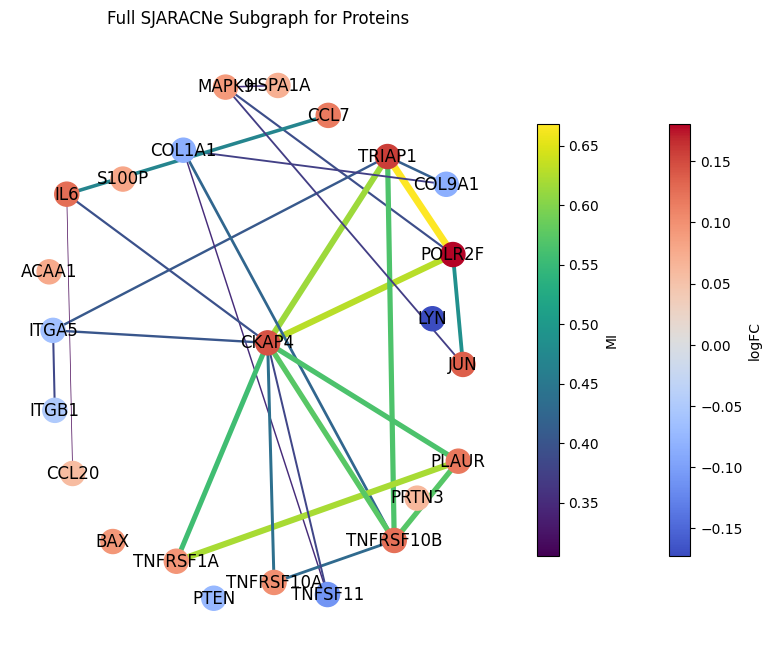

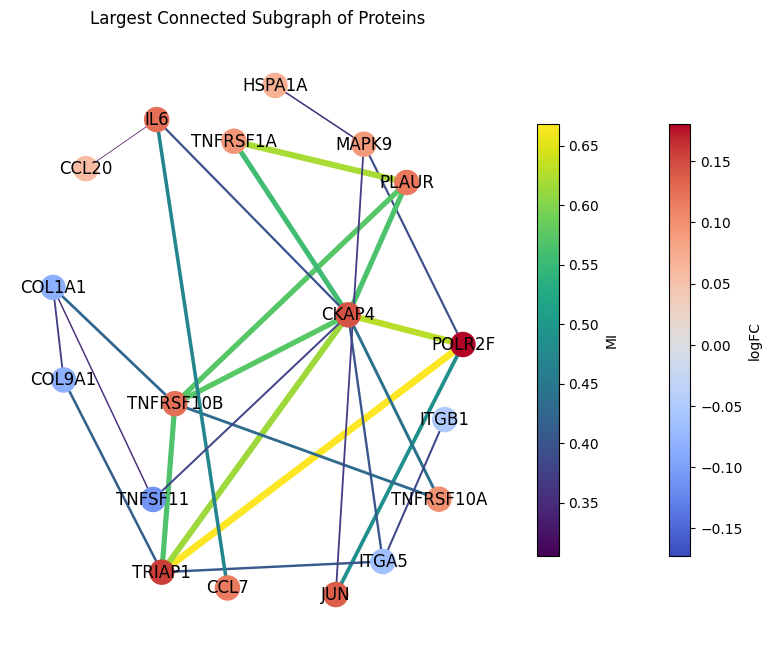

(<networkx.classes.graph.Graph at 0x169695c70>,
 <networkx.classes.graph.Graph at 0x169ad6960>)

In [15]:
SHAP_SJARACNe_subgraph(G)

# Signal propagation

In [16]:
# Create a subgraph containing only nodes with type 'proteins'
P = G.subgraph([node for node, attrs in G.nodes(data=True) if attrs.get('type') == 'proteins'])

# Check the subgraph
print(f"Original Network Nodes: {len(G.nodes)}")
print(f"Protein Network Nodes: {len(P.nodes)}")
print(f"Protein Network Edges: {len(P.edges)}")

Original Network Nodes: 1373
Protein Network Nodes: 1146
Protein Network Edges: 3772


We are going to initiate random walks from ACAA1 to find neighboring nodes through signal propagation

In [17]:
def systematic_walks_unweighted(graph, start_node, steps, num_walks=10):
    """
    Perform multiple unweighted random walks with different seeds and collect results.

    Parameters:
        graph (networkx.Graph): The graph to walk on.
        start_node (str): The starting node of the walk.
        steps (int): Number of steps in each random walk.
        num_walks (int): Number of random walks to perform.

    Returns:
        list: List of paths from each random walk.
        dict: Node visit counts across all walks.
    """
    import random  # Import random module

    paths = []
    visit_counts = {node: 0 for node in graph.nodes()}  # Initialize visit counts

    for seed in range(num_walks):
        random.seed(seed)  # Set the seed for reproducibility
        current_node = start_node
        path = [current_node]  # Track the path for this walk
        visited_nodes = set(path)  # Track visited nodes

        for _ in range(steps):
            neighbors = list(graph.neighbors(current_node))
            if not neighbors:  # If no neighbors, stop the walk
                break
            current_node = random.choice(neighbors)  # Choose a random neighbor
            path.append(current_node)
            visited_nodes.add(current_node)

        paths.append(path)
        for node in visited_nodes:
            visit_counts[node] += 1  # Increment visit count for each node

    return paths, visit_counts

In [18]:
# Perform systematic unweighted random walks
num_walks = 100
paths, visit_counts = systematic_walks_unweighted(H, start_node="ACAA1", steps=20, num_walks=num_walks)

# Print results
print(f"Paths from {num_walks} unweighted walks:")
for i, path in enumerate(paths):
    print(f"Walk {i+1}: {path}")

print("\nNode Visit Counts:")
for node, count in visit_counts.items():
    print(f"{node}: {count}")

Paths from 100 unweighted walks:
Walk 1: ['ACAA1', 'neutrophil mediated immunity (GO:0002446)', 'CKAP4', 'TRIAP1', 'ITGA5', 'CKAP4', 'neutrophil degranulation (GO:0043312)', 'CKAP4', 'POLR2F', 'positive regulation of gene expression (GO:0010628)', 'POLR2F', 'JUN', 'Photodynamic therapy-induced AP-1 survival signaling. WP3611', 'JUN', 'IL-18 signaling pathway WP4754', 'MAPK9', 'IL-18 signaling pathway WP4754', 'MAPK9', 'POLR2F', 'TRIAP1', 'POLR2F']
Walk 2: ['ACAA1', 'Neutrophil Degranulation R-HSA-6798695', 'PLAUR', 'Hemostasis R-HSA-109582', 'PLAUR', 'Neutrophil Degranulation R-HSA-6798695', 'CKAP4', 'neutrophil degranulation (GO:0043312)', 'CKAP4', 'POLR2F', 'MAPK9', 'IL-17 signaling pathway', 'CCL7', 'IL-17 signaling pathway', 'CCL7', 'Cytokine-cytokine receptor interaction', 'TNFSF11', 'COL1A1', 'TNFSF11', 'positive regulation of intracellular signal transduction (GO:1902533)', 'IL6']
Walk 3: ['ACAA1', 'Neutrophil Degranulation R-HSA-6798695', 'PLAUR', 'TNFRSF10B', 'Apoptosis Modula

Top 20 Nodes by Visit Counts (Cleaned Labels):
ACAA1: 100
CKAP4: 85
neutrophil mediated immunity: 63
Neutrophil Degranulation: 61
IL6: 59
PLAUR: 55
TNFRSF10B: 47
neutrophil activation involved in immune response: 46
JUN: 42
TNFRSF10A: 36
Pathogenic Escherichia coli infection: 36
TNFRSF1A: 35
MAPK9: 29
TRIAP1: 28
Hemostasis: 27
POLR2F: 25
Cytokine-cytokine receptor interaction: 25
neutrophil degranulation: 24
HSPA1A: 24
positive regulation of intracellular signal transduction: 23


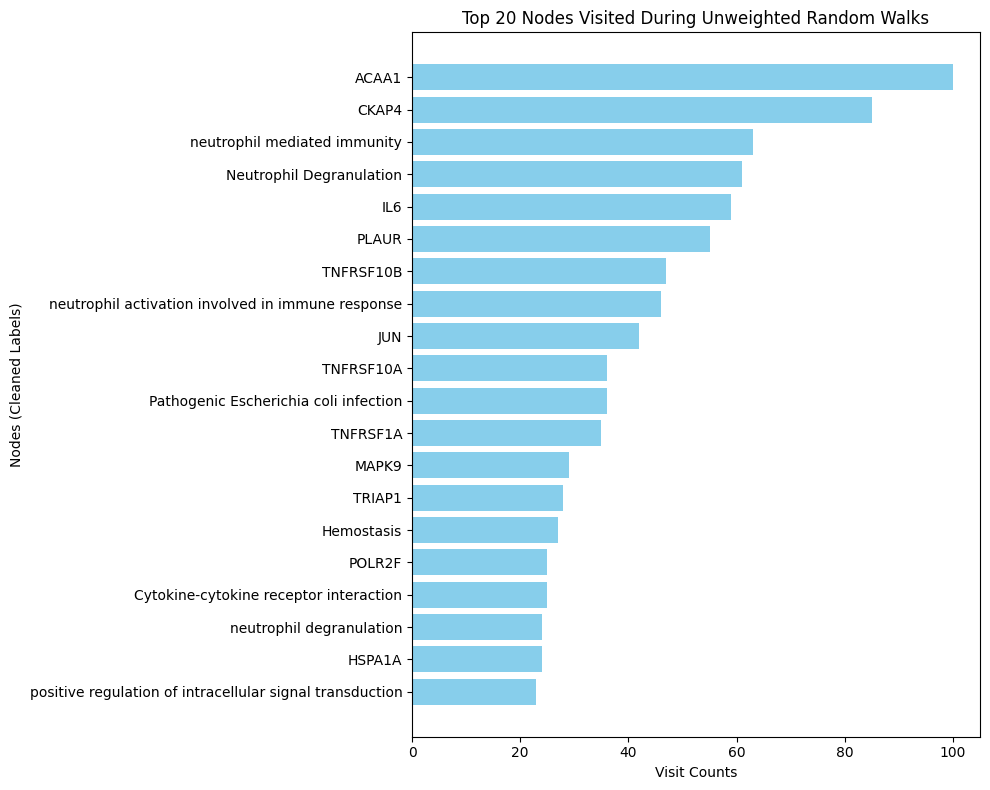

In [20]:
# Clean node labels
def clean_label(label):
    patterns = [r'R-HSA-\d+', r'WP\d+', r'\(GO:\d+\)']
    for pattern in patterns:
        label = re.sub(pattern, '', label)
    return label.strip()

# Clean the labels for all nodes
cleaned_labels = {node: clean_label(node) for node in visit_counts.keys()}

# Sort nodes by visit count in descending order and select the top 20
top_20_visits = dict(sorted(visit_counts.items(), key=lambda item: item[1], reverse=True)[:20])

# Apply cleaned labels to the top 20 nodes
cleaned_top_20_labels = {node: cleaned_labels[node] for node in top_20_visits.keys()}

# Print the top 20 nodes with cleaned labels
print("Top 20 Nodes by Visit Counts (Cleaned Labels):")
for node, count in top_20_visits.items():
    print(f"{cleaned_top_20_labels[node]}: {count}")

# Plot the top 20 nodes with cleaned labels using horizontal bars
plt.figure(figsize=(10, 8))
plt.barh(list(cleaned_top_20_labels.values()), top_20_visits.values(), color="skyblue")
plt.xlabel("Visit Counts")
plt.ylabel("Nodes (Cleaned Labels)")
plt.title("Top 20 Nodes Visited During Unweighted Random Walks")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
# plt.savefig("random_walks_acaa1.png", dpi=600, bbox_inches="tight")
plt.show()

In [21]:
# Visualize the subgraph of top visited nodes
def visualize_top_nodes_subgraph(graph, top_nodes):
    """
    Create and visualize a subgraph containing only the top visited nodes.

    Parameters:
        graph (networkx.Graph): The original graph.
        top_nodes (iterable): Nodes to include in the subgraph.
    """
    subgraph = graph.subgraph(top_nodes).copy()

    # Visualize the subgraph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw(
        subgraph,
        pos,
        with_labels=True,
        node_size=700,
        node_color="lightblue",
        edge_color="gray",
        font_size=10,
        font_color="black"
    )
    plt.title("Subgraph of Top 20 Visited Nodes")
    plt.tight_layout()
    # plt.savefig("top_nodes_subgraph.png", dpi=600, bbox_inches="tight")
    plt.show()

/var/folders/hr/f3msc_bs3z53n3_m4c4ry6tc0000gn/T/ipykernel_3053/3047155367.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


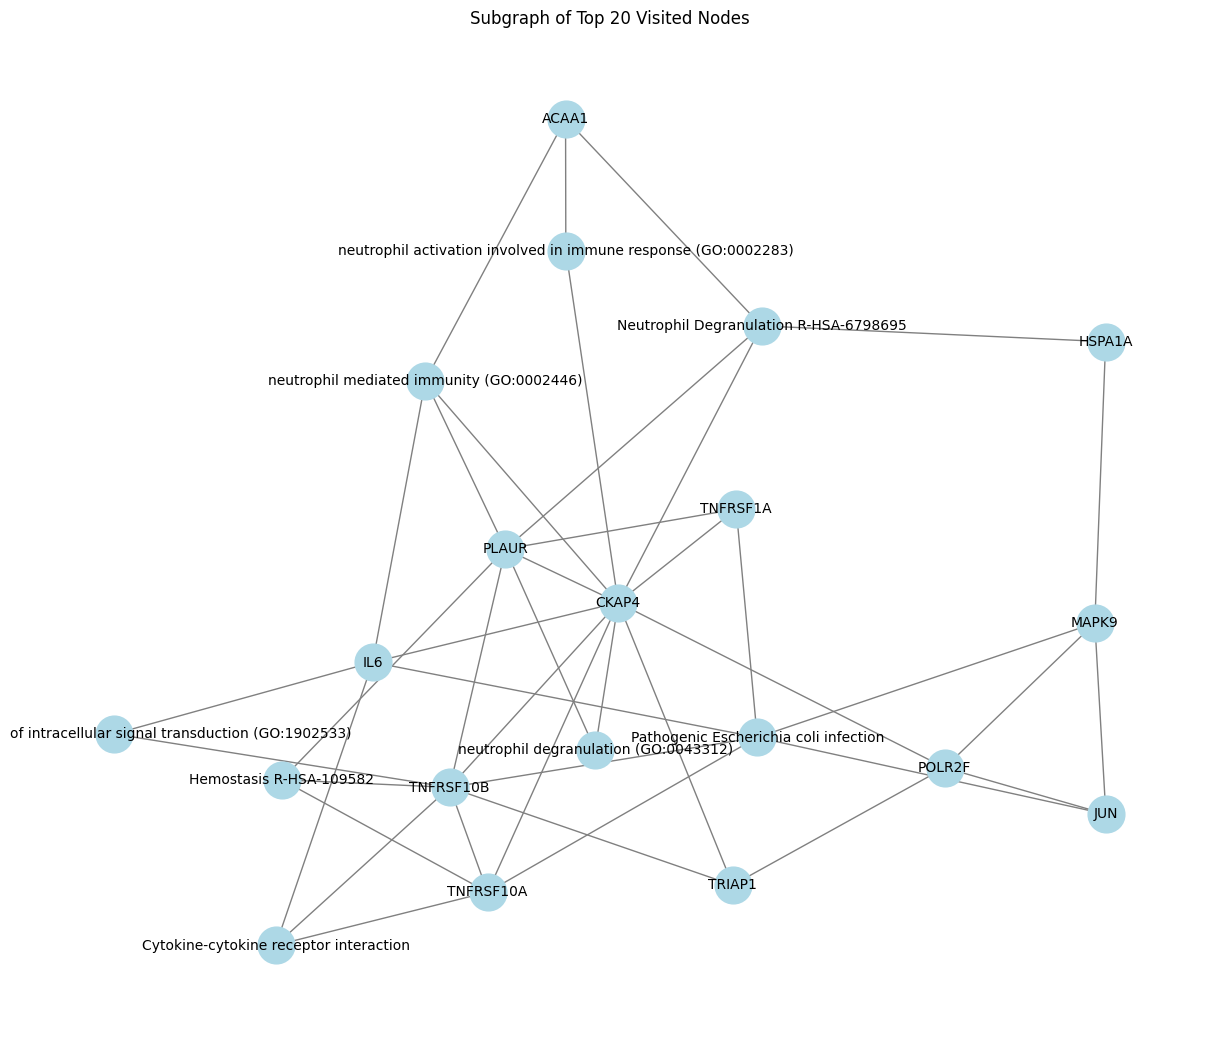

In [22]:
visualize_top_nodes_subgraph(H, top_20_visits)

# Shortest paths

In [13]:
def shortest_path_analysis(network, start_node, target_node):
    """Analyze and visualize the shortest path in the network."""
    logging.info(f"Analyzing shortest path from {start_node} to {target_node}.")

    # Filter the network to include only protein nodes
    protein_nodes = [node for node, attr in network.nodes(data=True) if attr.get('type') == 'proteins']
    protein_subgraph = network.subgraph(protein_nodes).copy()

    # Initialize the global shortest path subgraph
    global_shortest_path_subgraph = nx.DiGraph()

    # List to store all shortest paths
    all_shortest_paths = []

    # Function to add edges and nodes to the global subgraph
    def add_path_to_subgraph(path):
        path_edges = list(zip(path, path[1:]))
        global_shortest_path_subgraph.add_nodes_from(path)
        global_shortest_path_subgraph.add_edges_from(path_edges)

        # Copy logFC attributes to the global subgraph
        for node in path:
            global_shortest_path_subgraph.nodes[node]['logFC'] = protein_subgraph.nodes[node].get('logFC', None)
            global_shortest_path_subgraph.nodes[node]['Top20ShapDriver_or_pathway'] = protein_subgraph.nodes[node].get('Top20ShapDriver_or_pathway', 'no')

        # Copy MI and spearman attributes to the global subgraph
        for u, v in path_edges:
            global_shortest_path_subgraph[u][v]['MI'] = protein_subgraph[u][v].get('MI', None)
            global_shortest_path_subgraph[u][v]['spearman'] = protein_subgraph[u][v].get('spearman', None)

    # Function to draw edges with custom styles based on 'spearman' values
    def draw_custom_edges(subgraph, pos):
        for u, v, d in subgraph.edges(data=True):
            if d.get('spearman', 0) > 0:
                # Draw positive edges with arrows
                nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color='red',
                                       arrowstyle='-|>', arrows=True, arrowsize=15)
            else:
                # Draw negative edges with inhibition markers
                nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color='red',
                                       arrowstyle='-[', arrows=True, style='dashed', arrowsize=15)

    try:
        # Find the shortest path
        path = nx.shortest_path(protein_subgraph, start_node, target_node, weight='MI')
        logging.info(f"Shortest path from {start_node} to {target_node}: {path}")

        # Add the path to the global subgraph
        add_path_to_subgraph(path)

        # Add the path to the list of all shortest paths
        all_shortest_paths.append(path)

        # Create a subgraph consisting only of the nodes and edges in the current shortest path
        shortest_path_subgraph = global_shortest_path_subgraph.subgraph(path).copy()

        # Extract 'shap' values from node attributes for the nodes in the current shortest path subgraph
        blue_color = '#6baed6'  # Pastel blue
        orange_color = '#fd8d3c'  # Burnt orange
        node_colors = [blue_color if data.get('Top20ShapDriver_or_pathway', 'no') == 'yes' else orange_color
                       for _, data in shortest_path_subgraph.nodes(data=True)]

        # Visualize the current shortest path subgraph with node colors based on 'shap'
        pos = nx.spring_layout(shortest_path_subgraph, seed=42, k=1.5)  # Adjust k for more symmetrical spacing
        nx.draw_networkx_nodes(
            shortest_path_subgraph, pos,
            node_color=node_colors,
            node_size=300
        )
        draw_custom_edges(shortest_path_subgraph, pos)
        nx.draw_networkx_labels(shortest_path_subgraph, pos, font_size=10)
        nx.draw_networkx_edge_labels(
            shortest_path_subgraph, pos,
            edge_labels={(u, v): f"MI: {d.get('MI', 'N/A')}\nSp.: {d.get('spearman', 'N/A')}"
                         for u, v, d in shortest_path_subgraph.edges(data=True)},
            font_size=8
        )

        # Turn off the frame
        plt.gca().set_frame_on(False)
        plt.axis('off')

        # Set the title of the plot
        plt.title(f'Shortest path from {start_node} to {target_node} with weight', fontsize=12)
        # plt.savefig(f'shortest_path_{start_node}_{target_node}.png', format='png', dpi=300)
        plt.show()

    except nx.NetworkXNoPath:
        logging.warning(f"No path found from {start_node} to {target_node}.")

    # Output the list of all shortest paths
    logging.info(f"All shortest paths: {all_shortest_paths}")

    return all_shortest_paths, global_shortest_path_subgraph


Let's see how close ACAA1 is to one of the most pivotal proteins during Sars-CoV-2 infection ACE2

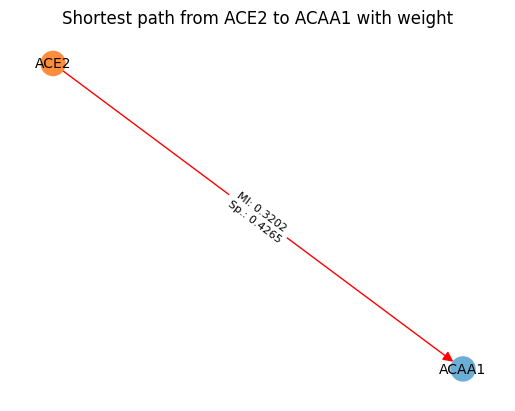

([['ACE2', 'ACAA1']], <networkx.classes.digraph.DiGraph at 0x168e60dd0>)

In [14]:
 shortest_path_analysis(G, "ACE2", "ACAA1")

The prior SJARANCne networks indicated that ACAA1 is not directly connected with other top SHAP drivers. So we are going to look of indirect connections looking for important intermediate nodes.

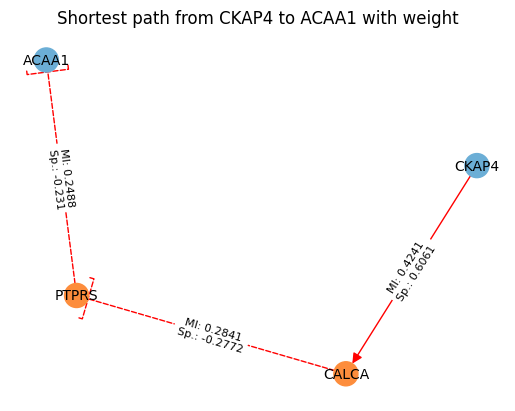

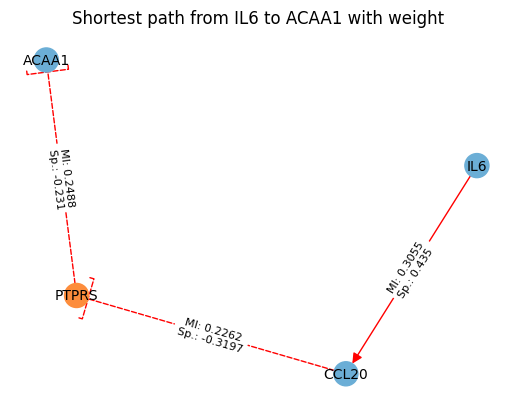

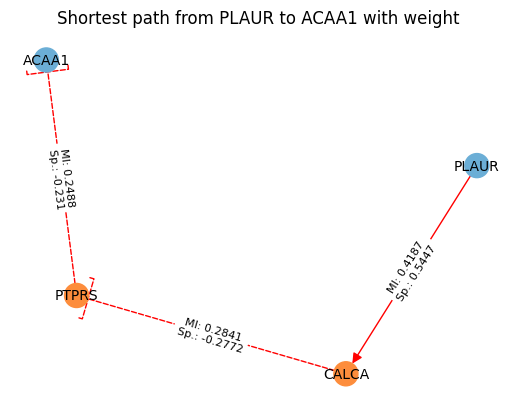

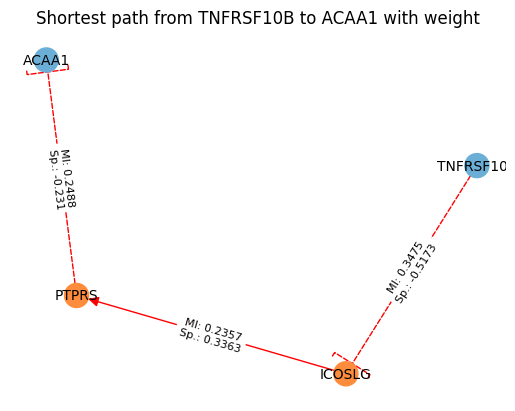

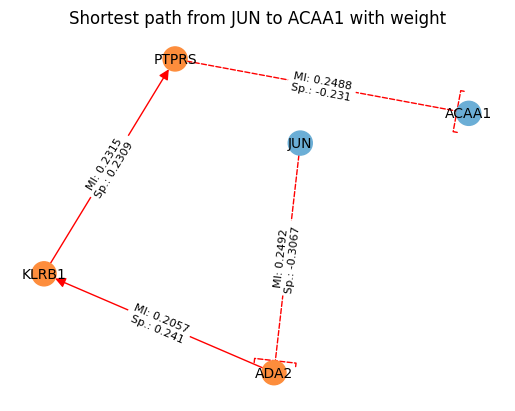

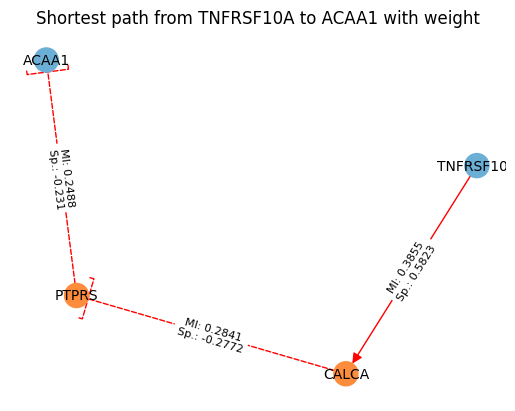

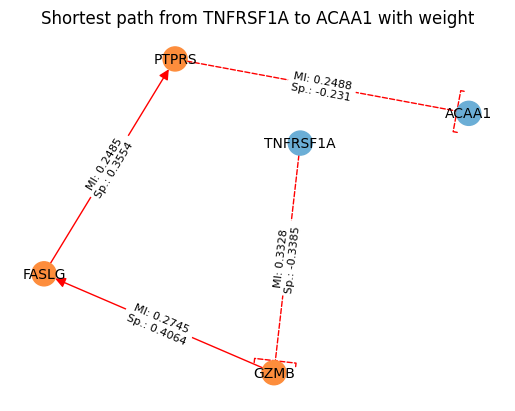

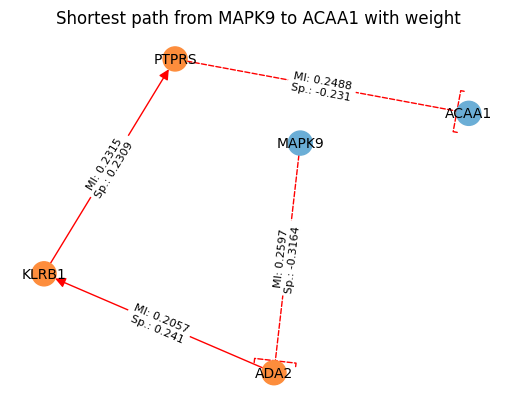

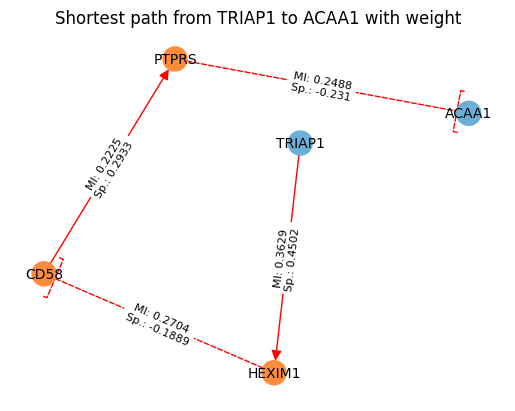

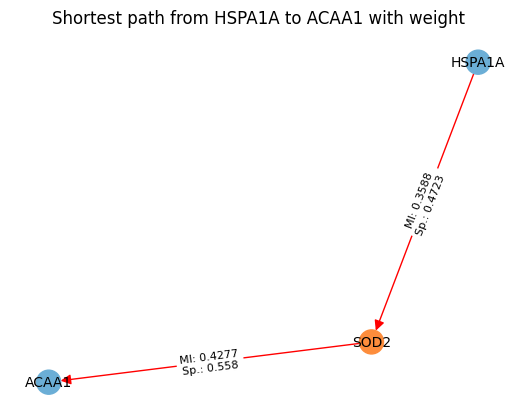

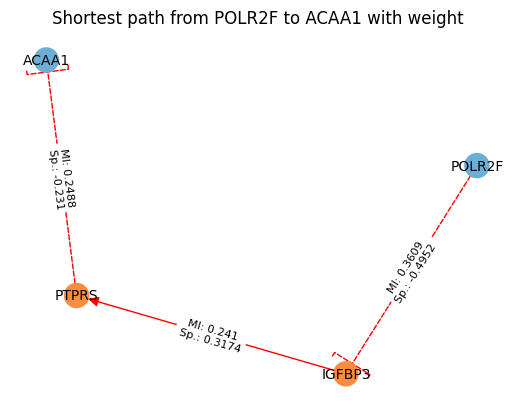

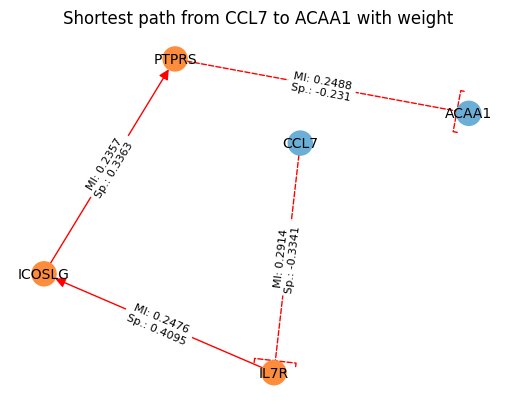

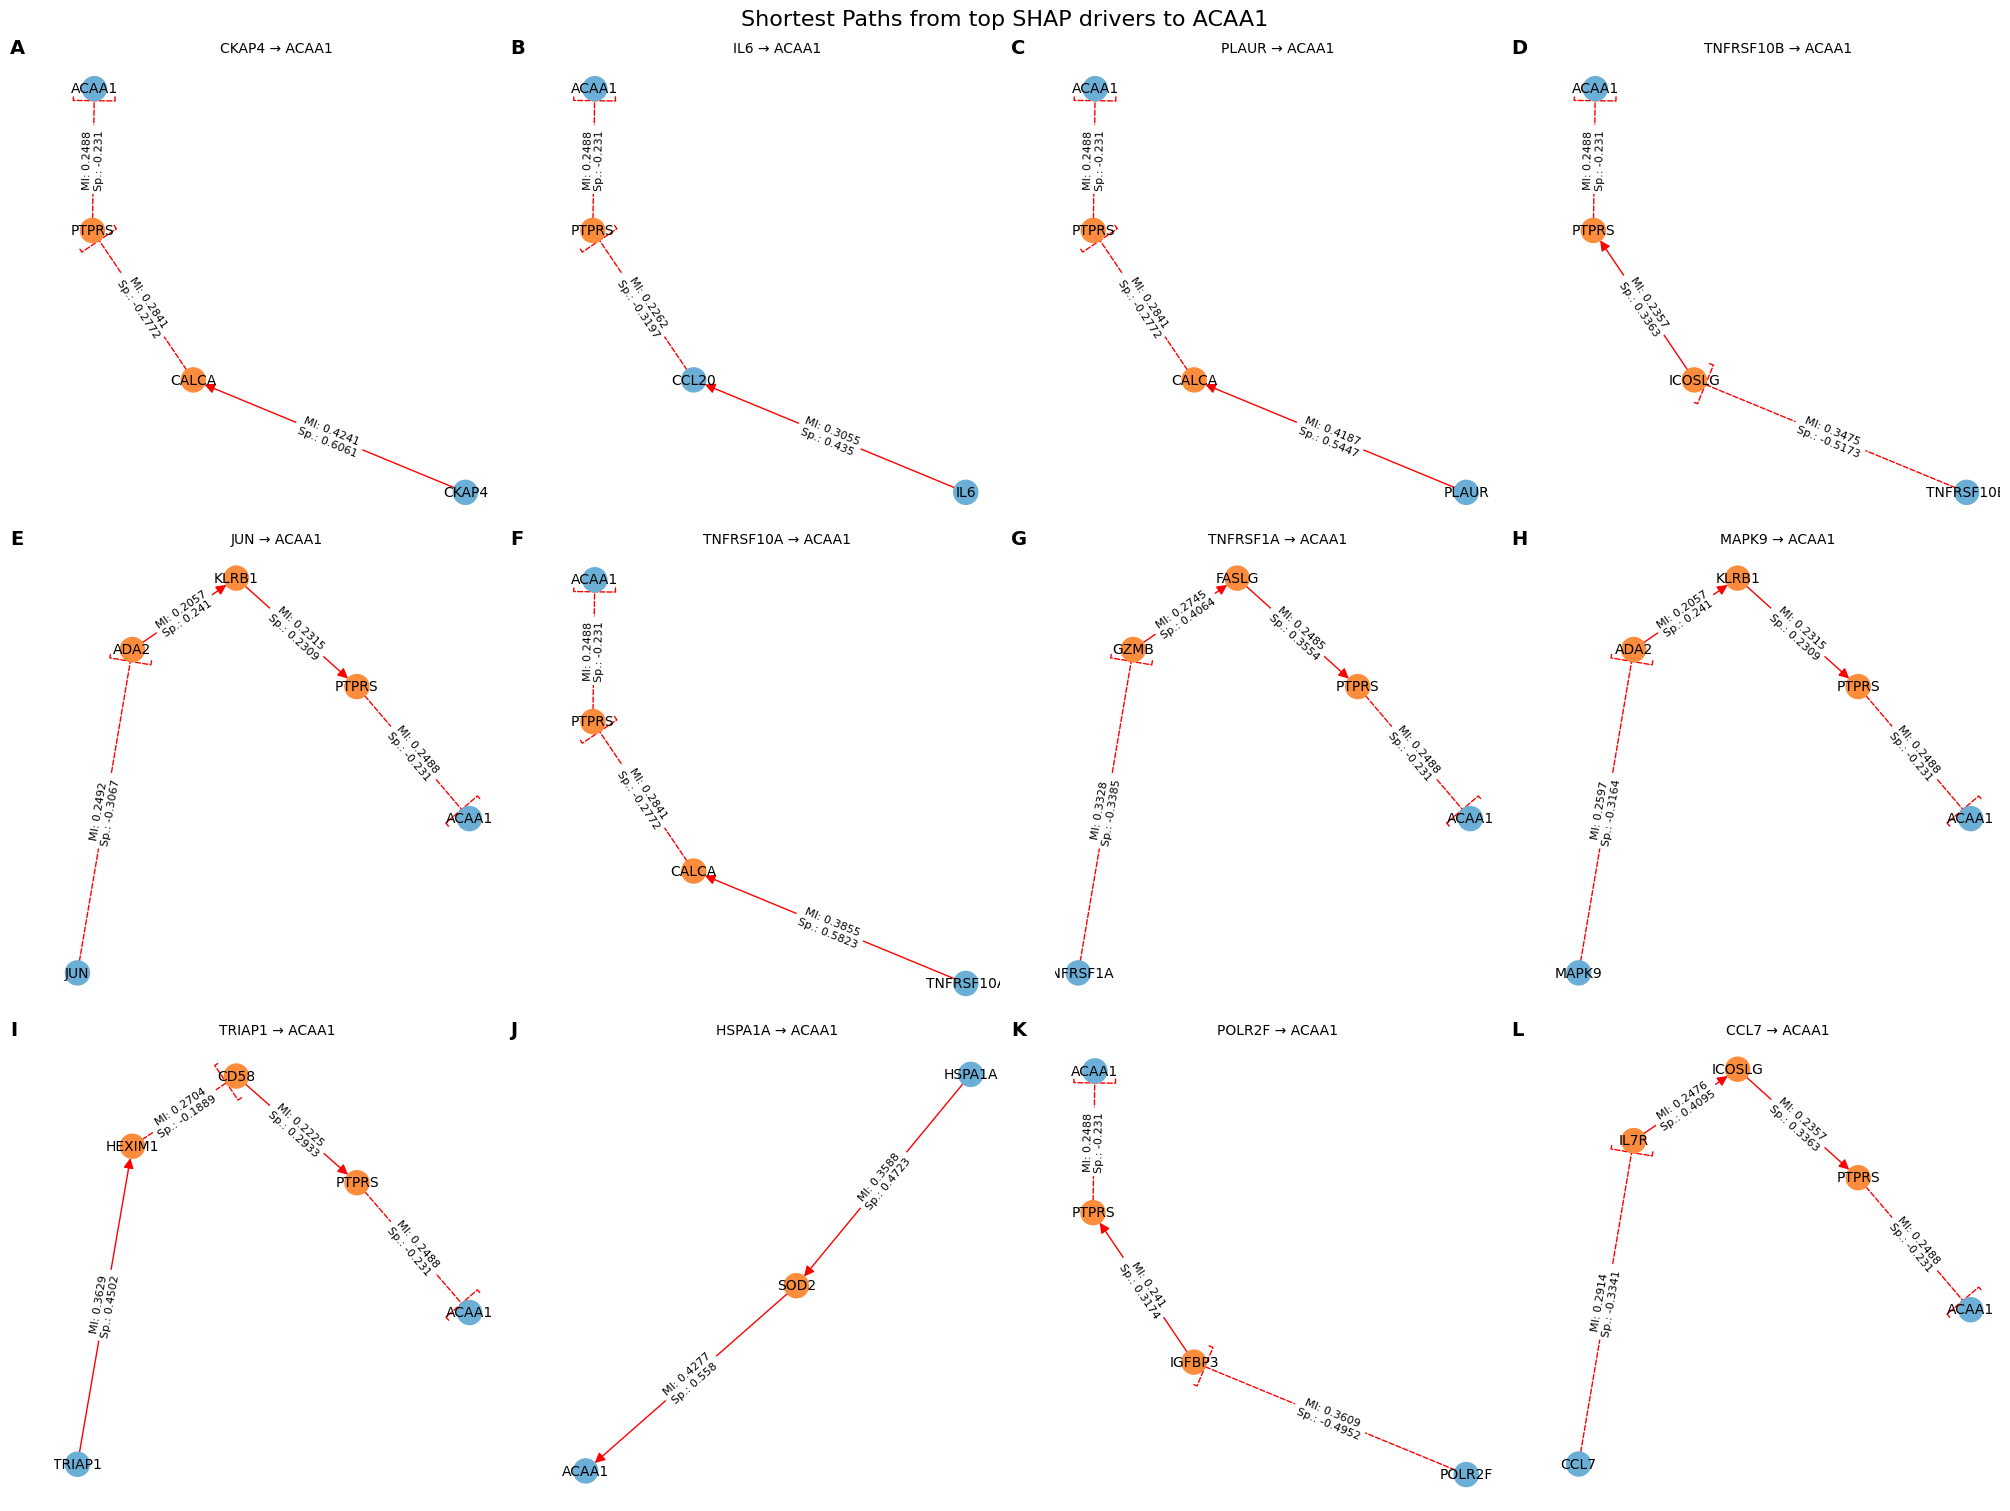

In [15]:
target_node = "ACAA1"
source_nodes = ["CKAP4", "IL6", "PLAUR", "TNFRSF10B", "JUN", "TNFRSF10A", "TNFRSF1A", "MAPK9", "TRIAP1", "HSPA1A", "POLR2F", "CCL7"]

# Create a dictionary to store results
all_results = {}

# Loop through each source node in the list
for source_node in source_nodes:
    logging.info(f"Processing shortest path from {source_node} to {target_node}...")
    try:
        # Call the function for each source node
        shortest_paths, subgraph = shortest_path_analysis(G, source_node, target_node)
        all_results[source_node] = {
            "shortest_paths": shortest_paths,
            "subgraph": subgraph
        }
    except Exception as e:
        logging.error(f"Error processing {source_node} to {target_node}: {e}")

# Determine grid size dynamically (prefer 4 columns)
num_plots = len(all_results)
grid_cols = 4
grid_rows = math.ceil(num_plots / grid_cols)

# Create the subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 5 * grid_rows), constrained_layout=True)

# Flatten the axes for easy indexing
axes = axes.flatten()

# Alphabet labels for subplots
labels = string.ascii_uppercase  # Generates 'A', 'B', 'C', ...

# Iterate through results and plot each shortest path in the grid
for i, (source_node, result) in enumerate(all_results.items()):
    ax = axes[i]
    subgraph = result["subgraph"]

    # Layout for the subgraph
    pos = nx.spring_layout(subgraph, seed=42)

    # Node colors based on 'Top20ShapDriver_or_pathway' attribute
    blue_color = '#6baed6'  # Pastel blue
    orange_color = '#fd8d3c'  # Burnt orange
    node_colors = [
        blue_color if data.get('Top20ShapDriver_or_pathway', 'no') == 'yes' else orange_color
        for _, data in subgraph.nodes(data=True)
    ]

    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=300, ax=ax)

    # Draw edges with custom styles
    for u, v, d in subgraph.edges(data=True):
        if d.get('spearman', 0) > 0:
            nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color='red',
                                   arrowstyle='-|>', arrows=True, arrowsize=15, ax=ax)
        else:
            nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color='red',
                                   arrowstyle='-[', arrows=True, style='dashed', arrowsize=15, ax=ax)

    # Draw labels
    nx.draw_networkx_labels(subgraph, pos, font_size=10, ax=ax)
    nx.draw_networkx_edge_labels(
        subgraph, pos,
        edge_labels={(u, v): f"MI: {d.get('MI', 'N/A')}\nSp.: {d.get('spearman', 'N/A')}"
                     for u, v, d in subgraph.edges(data=True)},
        font_size=8, ax=ax
    )

    # Add subplot title
    ax.set_title(f"{source_node} → {target_node}", fontsize=10)
    ax.axis('off')  # Turn off axes

    # Add alphabetical label to each subplot with adjusted position
    ax.annotate(labels[i], xy=(-0.1, 1.05), xycoords='axes fraction',
                fontsize=14, fontweight='bold', ha='left', va='top')

# Turn off unused subplots
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

# Display the multipanel figure
plt.suptitle('Shortest Paths from top SHAP drivers to ACAA1', fontsize=16)
# plt.savefig("SupFigure_rev_ACAA1.png", dpi=600, bbox_inches="tight")
plt.show()

In [16]:
# Collect all proteins involved in all shortest paths
all_proteins = set()

for source_node, result in all_results.items():
    shortest_paths = result["shortest_paths"]  # List of shortest paths
    for path in shortest_paths:
        all_proteins.update(path)  # Add all nodes in the path to the set

# Display the unique proteins
if all_proteins:
    print("Proteins involved in all shortest paths:")
    for protein in sorted(all_proteins):  # Sort for cleaner display
        print(protein)
else:
    print("No proteins found in the shortest paths.")

Proteins involved in all shortest paths:
ACAA1
ADA2
CALCA
CCL20
CCL7
CD58
CKAP4
FASLG
GZMB
HEXIM1
HSPA1A
ICOSLG
IGFBP3
IL6
IL7R
JUN
KLRB1
MAPK9
PLAUR
POLR2F
PTPRS
SOD2
TNFRSF10A
TNFRSF10B
TNFRSF1A
TRIAP1


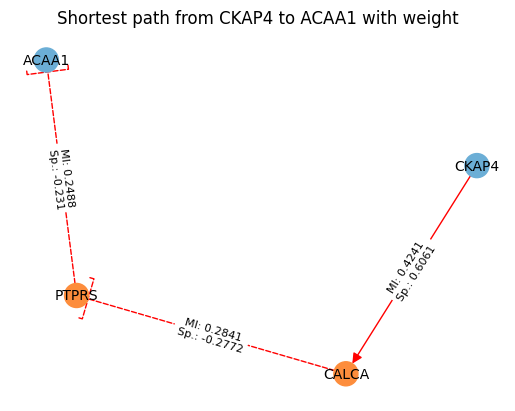

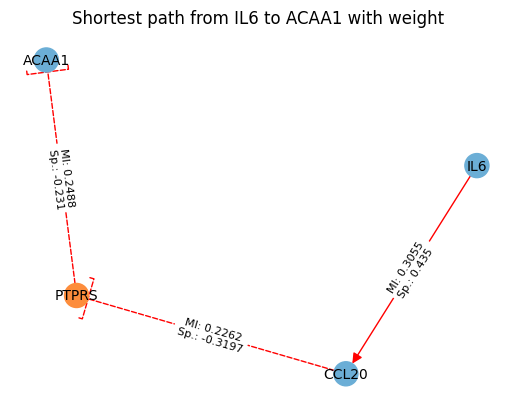

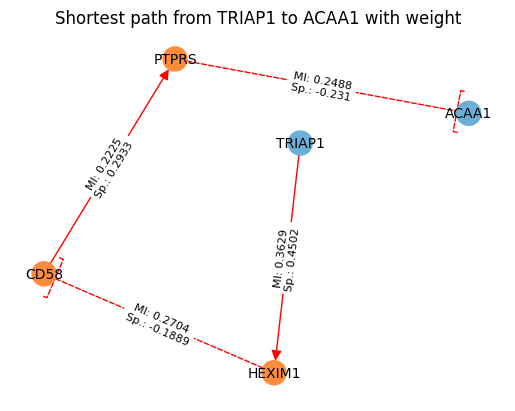

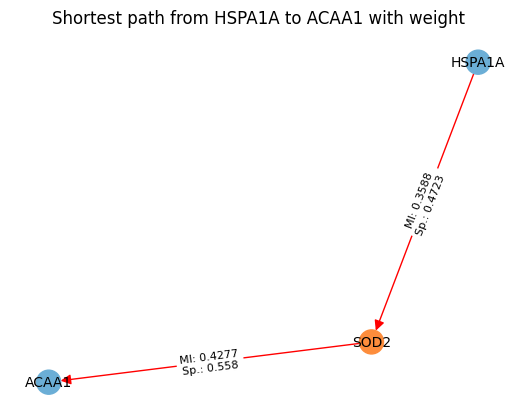

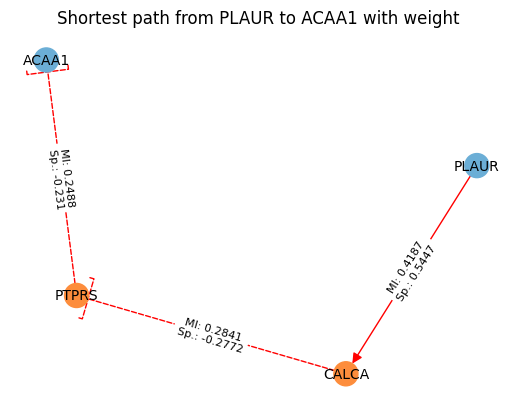

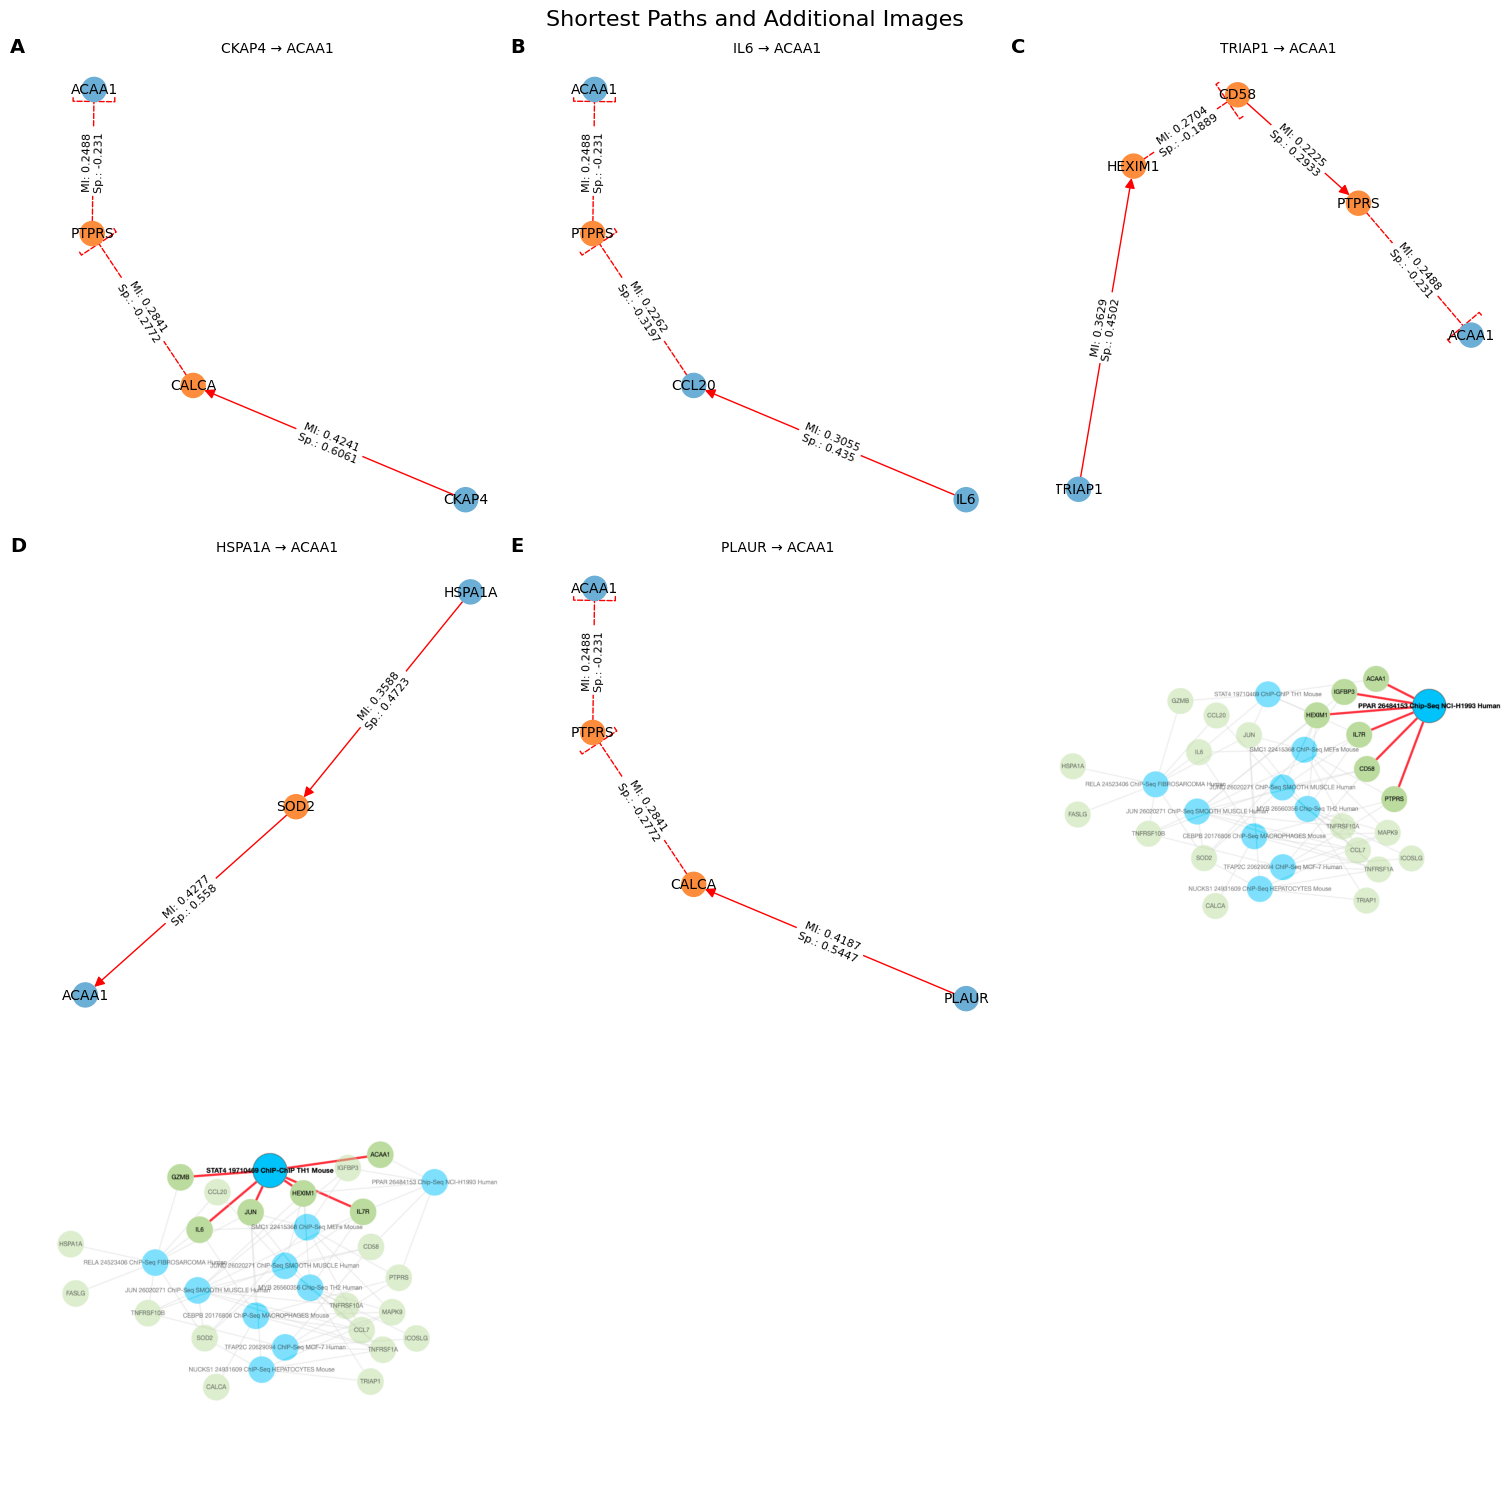

In [18]:
# Define the network (G), target node, and filtered list of source nodes
target_node = "ACAA1"
source_nodes = ["CKAP4", "IL6", "TRIAP1", "HSPA1A", "PLAUR"]  # Filtered proteins
additional_images = ["./results/Enrichr-KG/ACAA1_PPAR_Chea.png", "./results/Enrichr-KG/ACAA1_STAT4_Chea.png"]  # Paths to additional images

# Create a dictionary to store results
all_results = {}

# Loop through each source node in the filtered list
for source_node in source_nodes:
    logging.info(f"Processing shortest path from {source_node} to {target_node}...")
    try:
        # Call the function for each source node
        shortest_paths, subgraph = shortest_path_analysis(G, source_node, target_node)
        all_results[source_node] = {
            "shortest_paths": shortest_paths,
            "subgraph": subgraph
        }
    except Exception as e:
        logging.error(f"Error processing {source_node} to {target_node}: {e}")

# Combine the number of plots and images
num_plots = len(all_results) + len(additional_images)

# Determine grid size dynamically (prefer 3 columns)
grid_cols = 3
grid_rows = math.ceil(num_plots / grid_cols)

# Create the subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 5 * grid_rows), constrained_layout=True)

# Flatten the axes for easy indexing
axes = axes.flatten()

# Alphabet labels for subplots
labels = string.ascii_uppercase  # Generates 'A', 'B', 'C', ...

# Plot shortest paths
for i, (source_node, result) in enumerate(all_results.items()):
    ax = axes[i]
    subgraph = result["subgraph"]

    # Layout for the subgraph
    pos = nx.spring_layout(subgraph, seed=42)

    # Node colors based on 'Top20ShapDriver_or_pathway' attribute
    blue_color = '#6baed6'  # Pastel blue
    orange_color = '#fd8d3c'  # Burnt orange
    node_colors = [
        blue_color if data.get('Top20ShapDriver_or_pathway', 'no') == 'yes' else orange_color
        for _, data in subgraph.nodes(data=True)
    ]

    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=300, ax=ax)

    # Draw edges with custom styles
    for u, v, d in subgraph.edges(data=True):
        if d.get('spearman', 0) > 0:
            nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color='red',
                                   arrowstyle='-|>', arrows=True, arrowsize=15, ax=ax)
        else:
            nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v)], edge_color='red',
                                   arrowstyle='-[', arrows=True, style='dashed', arrowsize=15, ax=ax)

    # Draw labels
    nx.draw_networkx_labels(subgraph, pos, font_size=10, ax=ax)
    nx.draw_networkx_edge_labels(
        subgraph, pos,
        edge_labels={(u, v): f"MI: {d.get('MI', 'N/A')}\nSp.: {d.get('spearman', 'N/A')}"
                     for u, v, d in subgraph.edges(data=True)},
        font_size=8, ax=ax
    )

    # Add subplot title
    ax.set_title(f"{source_node} → {target_node}", fontsize=10)
    ax.axis('off')  # Turn off axes

    # Add alphabetical label to each subplot with adjusted position
    ax.annotate(labels[i], xy=(-0.1, 1.05), xycoords='axes fraction',
                fontsize=14, fontweight='bold', ha='left', va='top')

# Add PNG images to the multipanel
for j, img_path in enumerate(additional_images, start=len(all_results)):
    ax = axes[j]
    img = imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    #ax.set_title(f"Image {labels[j]}", fontsize=10)  # Add title to the image

# Turn off unused subplots
for k in range(num_plots, len(axes)):
    axes[k].axis('off')

# Display the multipanel figure
plt.suptitle('Shortest Paths and Additional Images', fontsize=16)
# plt.savefig("SupFigure_rev_ACAA1_with_images.png", dpi=600, bbox_inches="tight")
plt.show()

# Plotting Networks for original PASNet

In [11]:
def network_reconstruction_without_sjaracne(sc1_path, top_shap_proteins, differential_activity_path):
    """Reconstruct a network from SC1 data and differential activity data, omitting SJARACNe input."""
    logging.info("Reconstructing network using:")
    logging.info(f"- Deep Learning protein-pathway weights (SC1): {sc1_path}")
    logging.info(f"- Differential activity file: {differential_activity_path}")

    # Memory cleanup
    gc.collect()

    # Create graph
    G = nx.Graph()

    # Step 1: Load and process SC1 data
    try:
        correlation_matrix = pd.read_excel(sc1_path, engine='openpyxl', index_col=0)
        logging.info("SC1 file successfully loaded.")
        data = [
            (pathway, gene, value)
            for pathway, series in correlation_matrix.iterrows()
            for gene, value in series.items()
        ]
        df = pd.DataFrame(data, columns=['source', 'target', 'Weight'])

        # Remove edges with Weight == 0
        df = df[df['Weight'] != 0]

        # Mark top SHAP proteins
        df['handler'] = df.apply(lambda row: 'get' if row['source'] in top_shap_proteins or row['target'] in top_shap_proteins else None, axis=1)
    except Exception as e:
        logging.error(f"Error processing SC1 file: {e}")
        return None

    # Step 2: Load and process differential activity data
    try:
        node_attr_proteins = pd.read_csv(differential_activity_path)
        logging.info("Differential activity file successfully loaded.")

        # Replace problematic column names with underscores
        node_attr_proteins.columns = [col.replace('.', '_').replace('-', '_') for col in node_attr_proteins.columns]

        # Add default values for missing columns
        if 'type' not in node_attr_proteins.columns:
            node_attr_proteins['type'] = 'proteins'
        else:
            node_attr_proteins['type'] = node_attr_proteins['type'].fillna('proteins')
        node_attr_proteins['Top20ShapDriver_or_pathway'] = node_attr_proteins['ID'].apply(lambda x: 'yes' if x in top_shap_proteins else 'no')

        # Check for missing columns
        required_columns = ['label', 'type', 'ID', 'logFC', 'AveExpr', 't', 'P_Value', 'adj_P_Val', 'Z_statistics',
                            'Ave_NonSevere', 'Ave_Severe', 'Top20ShapDriver_or_pathway']
        missing_columns = [col for col in required_columns if col not in node_attr_proteins.columns]
        if missing_columns:
            logging.warning(f"Missing columns in node attributes: {missing_columns}")
    except Exception as e:
        logging.error(f"Error processing differential activity file: {e}")
        return None

    # Step 3: Add edges to the graph
    try:
        for row in df.itertuples(index=False):
            source, target = row.source, row.target
            edge_attributes = {col: getattr(row, col, None) for col in df.columns if col not in ['source', 'target']}
            if not G.has_edge(source, target):  # Prevent duplicate edges
                G.add_edge(source, target, **edge_attributes)
    except Exception as e:
        logging.error(f"Error adding edges to the graph: {e}")
        return None

    # Step 4: Add node attributes
    try:
        for row in node_attr_proteins.itertuples(index=False):
            if row.ID in G.nodes:
                attributes = row._asdict()
                attributes.pop('Index', None)  # Remove the index column
                G.nodes[row.ID].update(attributes)
    except Exception as e:
        logging.error(f"Error adding node attributes: {e}")
        return None

    # Step 5: Add label attribute
    try:
        for node in G.nodes:
            G.nodes[node]['label'] = str(node)  # Set 'label' attribute to node name (convert to string if needed)
    except Exception as e:
        logging.error(f"Error adding label attribute: {e}")
        return None

    # Step 6: Replace NaN in 'type' column with 'pathways'
    try:
        for node, data in G.nodes(data=True):
            if 'type' not in data or pd.isna(data['type']):
                G.nodes[node]['type'] = 'pathways'
    except Exception as e:
        logging.error(f"Error updating 'type' attribute: {e}")
        return None

    logging.info(f"Network constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

In [12]:
# Simulated arguments for testing in Colab
sc1_path = "Deep_Learning_outputs/sc1_weights_fixed_jan25.xlsx"

top_shap_proteins = [ "IL6", "NCF2", "TNFRSF10B", "CCL20", "DPY30", "CHI3L1", "AREG", "POLR2F", "AGR2", "CKAP4",
    "MMP8", "JUN", "CCL7", "FASLG", "BRK1", "TNFRSF10A", "IL1RAP", "ELOA", "TNFSF10", "TNFRSF1A",
    "HSPA1A", "TRIAP1", "MAPK9", "LGALS9", "CXCL8"]
# differential_activity_path = "NetBID2_DA/DA_MGH.csv"

# Run the function
G = network_reconstruction_without_sjaracne(sc1_path, top_shap_proteins, differential_activity_path)

# Optionally inspect the graph
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 371, Edges: 1542


In [14]:
# Sanity check 1: Inspect edge attributes
edge_attributes = [{'source': source, 'target': target, **attr}
                   for source, target, attr in G.edges(data=True)]

edge_df = pd.DataFrame(edge_attributes)

print("Edge Attributes:")
print(edge_df)

Edge Attributes:
                                                 source  \
0               16p11.2 distal deletion syndrome WP4950   
1               16p11.2 distal deletion syndrome WP4950   
2               16p11.2 distal deletion syndrome WP4950   
3                                                   CR2   
4                                                   CR2   
...                                                 ...   
1537  positive regulation of intracellular signal tr...   
1538                                                ENG   
1539                                                ENG   
1540                                                ENG   
1541                                                ENG   

                                                 target    Weight handler  
0                                                   CR2  0.001295    None  
1                                                   IL4  0.001274    None  
2                                             

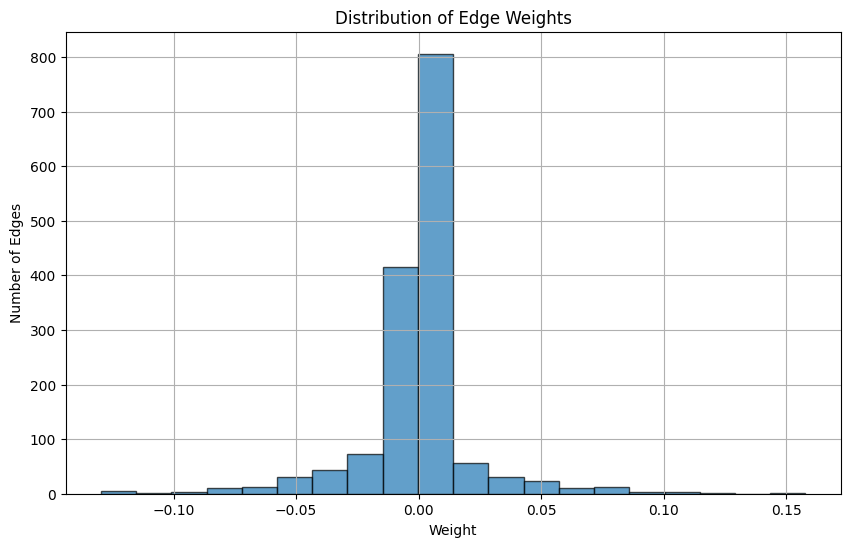

In [15]:
# Extract the 'Weight' attribute values from the edges
weight_values = [data['Weight'] for _, _, data in G.edges(data=True) if 'Weight' in data]


# Plot the distribution of weight values
plt.figure(figsize=(10, 6))
plt.hist(weight_values, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Number of Edges')
plt.grid(True)
plt.show()

In [18]:
import logging

In [19]:
def highlight_protein_pathway_subnetwork(network, lower_range=(-2.5, -1), upper_range=(1, 2.5)):
    """Highlight specific protein-pathway subnetworks."""
    logging.info("Highlighting protein-pathway subnetwork.")

    # Subset the graph based on edge attributes
    selected_edges = [(u, v) for u, v, e in network.edges(data=True) if e.get('handler') == 'get']
    H = nx.Graph(((u, v, e) for u, v, e in network.edges(data=True) if e.get('handler') == 'get'))

    # Transfer node attributes
    for node, data in network.nodes(data=True):
        if node in H.nodes:
            H.nodes[node].update(data)

    # Filter edges based on weight ranges
    filtered_edges = [(u, v) for u, v, data in H.edges(data=True)
                      if ('Weight' in data and
                          (np.isnan(data['Weight']) or
                           (lower_range[0] <= data['Weight'] <= lower_range[1]) or
                           (upper_range[0] <= data['Weight'] <= upper_range[1])))]

    filtered_subgraph = H.edge_subgraph(filtered_edges).copy()
    logging.info(f"Filtered subgraph has {len(filtered_subgraph.nodes())} nodes and {len(filtered_subgraph.edges())} edges.")

    # Degree-centrality and largest connected component
    components = nx.connected_components(filtered_subgraph)
    largest_component = max(components, key=len)
    F = filtered_subgraph.subgraph(largest_component).copy()

    # Compute centrality
    centrality = nx.betweenness_centrality(F, k=10, endpoints=True)

    # Compute community structure
    lpc = nx.community.label_propagation_communities(F)
    community_index = {n: i for i, com in enumerate(lpc) for n in com}

    # Clean node labels
    def clean_label(label):
        patterns = [r'R-HSA-\d+', r'WP\d+', r'\(GO:\d+\)']
        for pattern in patterns:
            label = re.sub(pattern, '', label)
        return label.strip()

    cleaned_labels = {node: clean_label(node) for node in F.nodes()}

    # Re-draw graph with cleaned labels
    fig, ax = plt.subplots(figsize=(9, 6))
    pos = nx.spring_layout(F, k=0.7, seed=4572321)
    node_color = [community_index[n] for n in F]
    node_size = [v * 5000 for v in centrality.values()]

    nx.draw_networkx_nodes(
        F,
        pos=pos,
        node_color=node_color,
        node_size=node_size,
        alpha=0.4
    )
    nx.draw_networkx_edges(
        F,
        pos=pos,
        edge_color="gainsboro",
        alpha=0.4
    )

    texts = []
    for node, label in cleaned_labels.items():
        x, y = pos[node]
        text = ax.text(x, y, label, fontsize=6, ha='center', va='center')
        texts.append(text)

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")

    plt.savefig('highlighted_subnetwork.png', format='png', dpi=300)
    plt.show()

    print(f"Network constructed with {F.number_of_nodes()} nodes and {F.number_of_edges()} edges.")

    return F

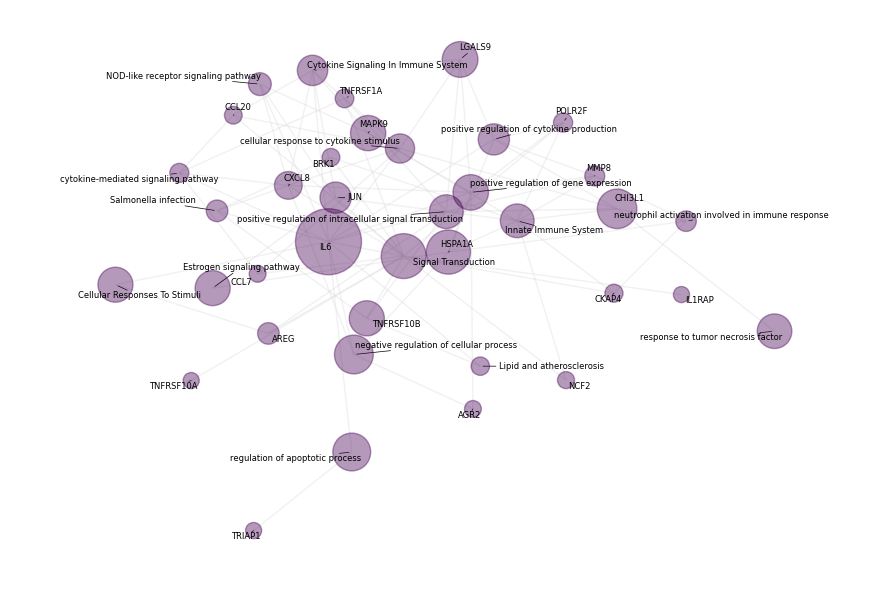

Network constructed with 38 nodes and 88 edges.


In [20]:
H = highlight_protein_pathway_subnetwork(
    network=G,
    lower_range=(-0.01, -0.4),
    upper_range=(0.01, 0.4)
)

# Multipaneling

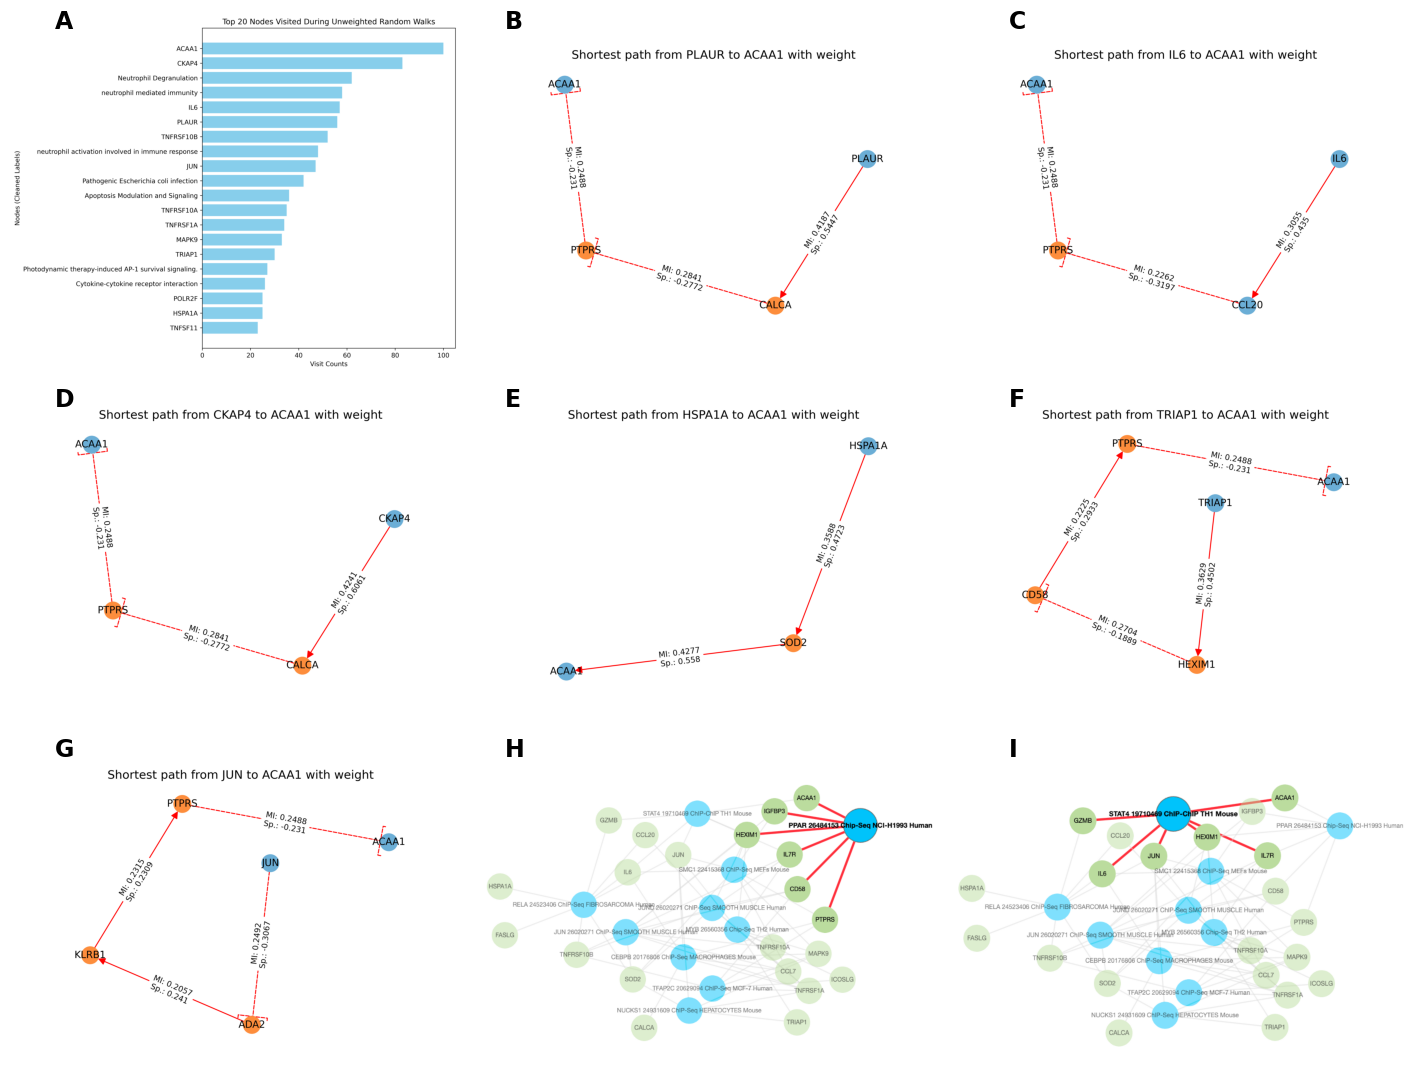

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the image files
image_files = [
    "./results/random_walks/random_walks_acaa1.png",
    "./results/shortest_paths/shortest_path_PLAUR_ACAA1.png",
    "./results/shortest_paths/shortest_path_IL6_ACAA1.png",
    "./results/shortest_paths/shortest_path_CKAP4_ACAA1.png",
    "./results/shortest_paths/shortest_path_HSPA1A_ACAA1.png",
    "./results/shortest_paths/shortest_path_TRIAP1_ACAA1.png",
    "./results/shortest_paths/shortest_path_JUN_ACAA1.png",
    "./results/Enrichr-KG/ACAA1_PPAR_Chea.png",
    "./results/Enrichr-KG/ACAA1_STAT4_Chea.png"
]

# Create the figure with further reduced vertical spacing
fig, axs = plt.subplots(3, 3, figsize=(18, 14))  # Adjusted figure size to reduce height
fig.subplots_adjust(wspace=0.05, hspace=0.005)  # Minimized spacing further

# Loop through the images and axes
for i, ax in enumerate(axs.flat):
    if i < len(image_files):
        try:
            img = Image.open(image_files[i])
            ax.imshow(img)
            ax.axis("off")  # Turn off the axes
        except FileNotFoundError:
            print(f"File not found: {image_files[i]}")
            ax.axis("off")  # Turn off axes for missing images
    else:
        ax.axis("off")  # Turn off unused subplots

fig.text(0.15, 0.87, 'A', size=17, weight='bold', ha='left')  # Panel A
fig.text(0.40, 0.87, 'B', size=17, weight='bold', ha='left')  # Panel B
fig.text(0.68, 0.87, 'C', size=17, weight='bold', ha='left')  # Panel C
fig.text(0.15, 0.60, 'D', size=17, weight='bold', ha='left')  # Panel D
fig.text(0.40, 0.60, 'E', size=17, weight='bold', ha='left')  # Panel E
fig.text(0.68, 0.60, 'F', size=17, weight='bold', ha='left')  # Panel F
fig.text(0.15, 0.35, 'G', size=17, weight='bold', ha='left')  # Panel G
fig.text(0.40, 0.35, 'H', size=17, weight='bold', ha='left')  # Panel H
fig.text(0.68, 0.35, 'I', size=17, weight='bold', ha='left')  # Panel I

# Save the adjusted figure
output_file = "Figure5_rev.png"
# plt.savefig(output_file, dpi=600, bbox_inches='tight')
plt.show()

In [25]:
!pwd

/Users/georgegavriilidis/APNet


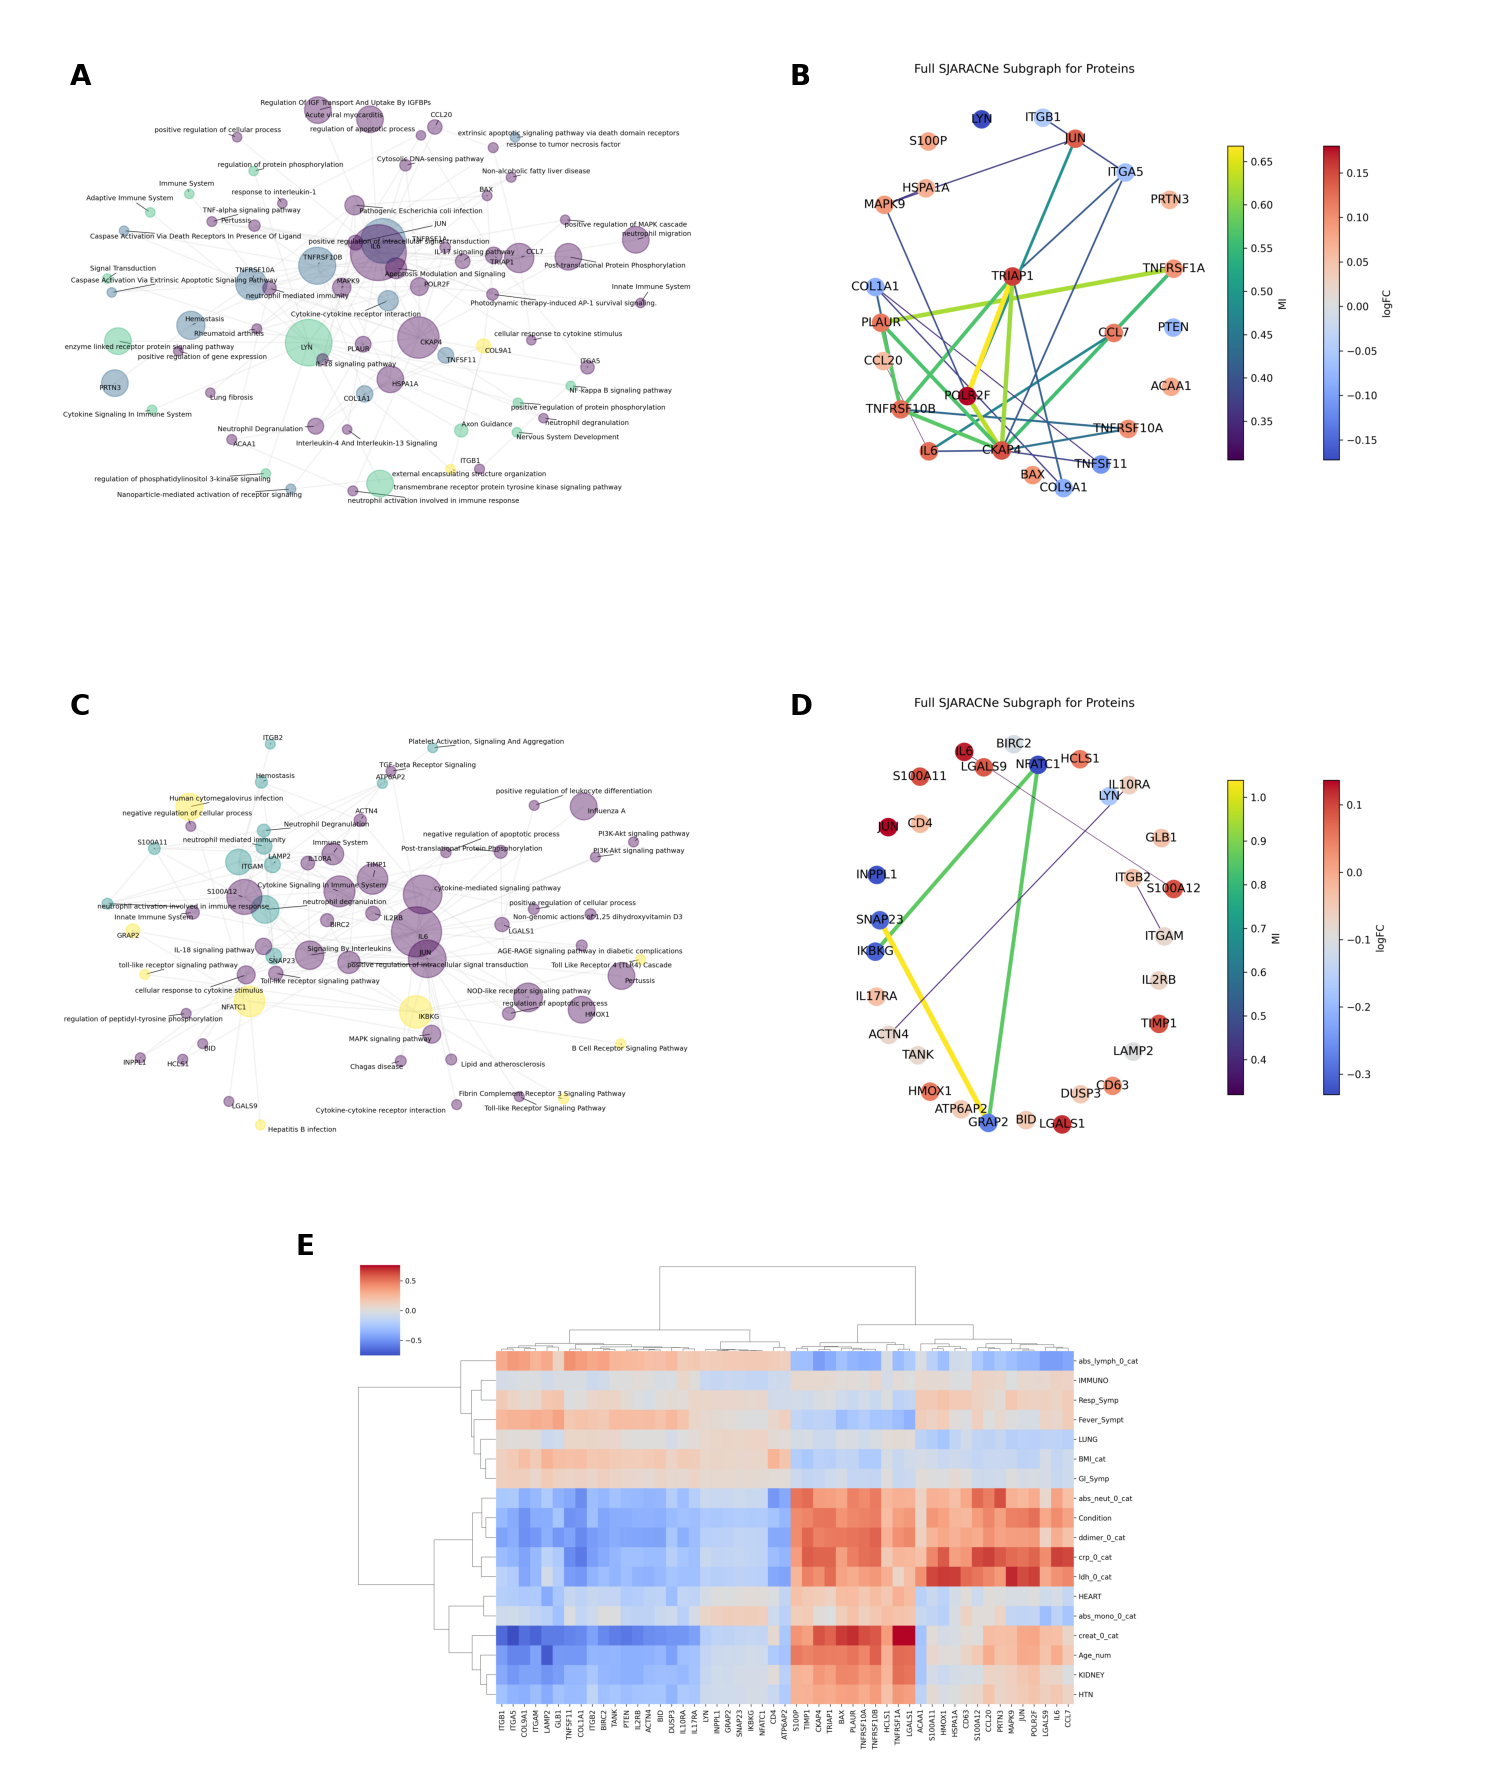

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec

# Load the PNG images
image1 = mpimg.imread('./results/bipartite_graphs/highlighted_subnetwork_Figure4_A.png')
image2 = mpimg.imread('./results/SJARACNe_SHAP/full_SJARACNe_subgraph_APNet_model_1_B.png')
image3 = mpimg.imread('./results/bipartite_graphs/highlighted_subnetwork_single_cell_Figure4_C.png')
image4 = mpimg.imread('./results/SJARACNe_SHAP/full_SJARACNe_subgraph_single_cell_APNet_model_2_D.png')
image5 = mpimg.imread('./results/clinical/clinical_APNet.png')

# Create a figure with a custom grid layout
fig = plt.figure(figsize=(15, 18))  # Increased height for better proportions
gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 0.8])  # Last row has larger height

# Plot the first four images in a 2x2 grid
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[1, 1]))

images = [image1, image2, image3, image4]

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')

# Add the 5th image spanning the entire bottom row
ax5 = fig.add_subplot(gs[2, :])  # Span both columns
ax5.imshow(image5)
ax5.axis('off')

# Add free text annotations for each figure
# First row
fig.text(0.05, 0.95, 'A', size=20, weight='bold', ha='left', va='top')  # Label for image1
fig.text(0.53, 0.95, 'B', size=20, weight='bold', ha='left', va='top')  # Label for image2

# Second row
fig.text(0.05, 0.60, 'C', size=20, weight='bold', ha='left', va='top')  # Label for image3
fig.text(0.53, 0.60, 'D', size=20, weight='bold', ha='left', va='top')  # Label for image4

# Bottom row
fig.text(0.20, 0.3, 'E', size=20, weight='bold', ha='left', va='top')  # Label for image5

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the figure
plt.savefig('Figure_4.png', dpi=300)

# Show the plot
plt.show()